In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

!ls /kaggle/input/

# Any results you write to the current directory are saved as output.

e059-question-snapshot	e074-xlnet-question	huggingface-model-configs
e060-answer-snapshot	e075-xlnet-answer	sacremoses-master
e068-roberta-question	google-quest-challenge	sub-bert1-roberta2-gpt0-xlnet1
e070-roberta-answer	guchio-transformers


In [2]:
!ls /kaggle/input/e059-question-snapshot
!ls /kaggle/input/e060-answer-snapshot
!ls /kaggle/input/huggingface-model-configs
!ls /kaggle/input/sub-bert1-roberta2-gpt0-xlnet1

added_tokens.json  special_tokens_map.json  tokenizer_config.json
optRs.pkl	   state_dicts		    vocab.txt
added_tokens.json  special_tokens_map.json  tokenizer_config.json
optRs.pkl	   state_dicts		    vocab.txt
bert-model-uncased-config.pkl  roberta-model-base-config.pkl
gpt2-model-config.pkl	       xlnet-model-base-cased-config.pkl
optRs.pkl


In [3]:
test_df = pd.read_csv('/kaggle/input/google-quest-challenge/test.csv')

## pre-settings

In [4]:
import os

def OSprint(string):
    os.system(f'echo \"{string}\"')
    print(string)

In [5]:
NUM_FOLDS = 5
DEVICE = 'cuda'
#DEVICE = 'cpu'
BATCH_SIZE = 8

In [6]:
!pip install /kaggle/input/sacremoses-master/sacremoses > /dev/null
#!pip install /kaggle/input/transformers/transformers-master #> /dev/null
!pip install --no-deps /kaggle/input/guchio-transformers/*.whl #> /dev/null

Processing /kaggle/input/guchio-transformers/boto3-1.10.46-py2.py3-none-any.whl
Processing /kaggle/input/guchio-transformers/botocore-1.13.46-py2.py3-none-any.whl
Processing /kaggle/input/guchio-transformers/numpy-1.18.0-cp36-cp36m-manylinux1_x86_64.whl
Processing /kaggle/input/guchio-transformers/regex-2019.12.20-cp36-cp36m-manylinux2010_x86_64.whl
Processing /kaggle/input/guchio-transformers/s3transfer-0.2.1-py2.py3-none-any.whl
Processing /kaggle/input/guchio-transformers/six-1.13.0-py2.py3-none-any.whl
  Found existing installation: boto3 1.11.9
    Uninstalling boto3-1.11.9:
      Successfully uninstalled boto3-1.11.9
  Found existing installation: botocore 1.14.9
    Uninstalling botocore-1.14.9:
      Successfully uninstalled botocore-1.14.9
  Found existing installation: numpy 1.18.1
    Uninstalling numpy-1.18.1:
      Successfully uninstalled numpy-1.18.1
  Found existing installation: regex 2020.1.8
    Uninstalling regex-2020.1.8:
      Successfully uninstalled regex-2020.1

In [7]:
import transformers
from transformers import BertModel, BertTokenizer, RobertaModel, RobertaTokenizer, XLNetModel, XLNetTokenizer
import random
from math import ceil, floor
import pandas as pd
from torch.utils.data import Dataset
from tqdm.notebook import tqdm

In [8]:
OSprint('start training!')

start training!


## BERT

In [9]:
def seed_everything(seed=71):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything()



def test(model, loader, tta=False):
    model.eval()

    with torch.no_grad():
        y_preds, qa_ids = [], []

        running_loss = 0
        for (qa_id, input_ids, attention_mask,
             token_type_ids, cat_labels, position_ids, labels) in tqdm(loader):
            # send them to DEVICE
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            token_type_ids = token_type_ids.to(DEVICE)
            labels = labels.to(DEVICE)

            # forward
            outputs = model(
                input_ids=input_ids,
                labels=labels,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
            )
            logits = outputs[0]

            y_preds.append(nn.functional.sigmoid(logits))
            qa_ids.append(qa_id)

        y_preds = torch.cat(y_preds).to('cpu').numpy()
        qa_ids = torch.cat(qa_ids).to('cpu').numpy()

    return y_preds, qa_ids

In [10]:
# --- dataset ---
class QUESTDataset(Dataset):
    def __init__(self, df, mode, tokens, augment,
                 pretrained_model_name_or_path, TBSEP='[TBSEP]',
                 MAX_SEQUENCE_LENGTH=None, use_category=True, logger=None,
                 t_max_len=30, q_max_len=239, a_max_len=239):
        self.t_max_len = t_max_len
        self.q_max_len = q_max_len
        self.a_max_len = a_max_len
        
        self.mode = mode
        self.augment = augment
        self.len = len(df)
        self.TBSEP = TBSEP
        if MAX_SEQUENCE_LENGTH:
            self.MAX_SEQUENCE_LENGTH = MAX_SEQUENCE_LENGTH
        else:
            raise NotImplementedError
            # self.MAX_SEQUENCE_LENGTH = -1
            # for i, row in self.prep_df.iterrows():
            #     input_ids = row['input_ids'].squeeze()
            #     if self.MAX_SEQUENCE_LENGTH < len(input_ids):
            #         self.MAX_SEQUENCE_LENGTH = len(input_ids)
            # sel_log(f'calculated seq_len: {self.MAX_SEQUENCE_LENGTH}', logger)
        self.use_category = use_category
        self.logger = logger
        self.cat_dict = {
            'CAT_TECHNOLOGY'.casefold(): 0,
            'CAT_STACKOVERFLOW'.casefold(): 1,
            'CAT_CULTURE'.casefold(): 2,
            'CAT_SCIENCE'.casefold(): 3,
            'CAT_LIFE_ARTS'.casefold(): 4,
        }

        if mode == "test":
            self.labels = pd.DataFrame([[-1] * 21] * len(df))
        else:  # train or valid
            self.labels = df.iloc[:, 11:]

        self.tokenizer = BertTokenizer.from_pretrained(
            pretrained_model_name_or_path)
        # self.tokenizer.add_special_tokens(
        #     {'additional_special_tokens': [self.TBSEP]})
        self.tokenizer.add_tokens([self.TBSEP])

        tokens = [token.encode('ascii', 'replace').decode()
                  for token in tokens if token != '']
        added_num = self.tokenizer.add_tokens(tokens)
        if logger:
            logger.info(f'additional_tokens : {added_num}')
        else:
            print(f'additional_tokens : {added_num}')
        # change online preprocess or off line preprocess
        self.original_df = df
        # res = self._preprocess_texts(df)
        # self.prep_df = df.merge(pd.DataFrame(res), on='qa_id', how='left')

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        # change online preprocess or off line preprocess
        # idx_row = self.prep_df.iloc[idx]
        idx_row = self.original_df.iloc[idx].copy()
        # idx_row = self._augment(idx_row)
        idx_row = self.__preprocess_text_row(idx_row,
                                             t_max_len=self.t_max_len,
                                             q_max_len=self.q_max_len,
                                             a_max_len=self.a_max_len)
                                             # t_max_len=30,
                                             # q_max_len=239,
                                             # a_max_len=239)
                                             # t_max_len=100,
                                             # q_max_len=700,
                                             # a_max_len=700)
        input_ids = idx_row['input_ids'].squeeze()
        token_type_ids = idx_row['token_type_ids'].squeeze()
        attention_mask = idx_row['attention_mask'].squeeze()
        qa_id = idx_row['qa_id'].squeeze()
        # cat_labels = idx_row['cat_label'].squeeze()
        cat_labels = -1
        position_ids = torch.arange(self.MAX_SEQUENCE_LENGTH)

        labels = self.labels.iloc[idx].values
        return qa_id, input_ids, attention_mask, \
            token_type_ids, cat_labels, position_ids, labels

    def _trim_input(self, title, question, answer,
                    t_max_len, q_max_len, a_max_len):

        t_len = len(title)
        q_len = len(question)
        a_len = len(answer)

        if (t_len + q_len + a_len + 4) > self.MAX_SEQUENCE_LENGTH:
            if t_max_len > t_len:
                t_new_len = t_len
                a_max_len = a_max_len + floor((t_max_len - t_len) / 2)
                q_max_len = q_max_len + ceil((t_max_len - t_len) / 2)
            else:
                t_new_len = t_max_len

            if a_max_len > a_len:
                a_new_len = a_len
                q_new_len = q_max_len + (a_max_len - a_len)
            elif q_max_len > q_len:
                a_new_len = a_max_len + (q_max_len - q_len)
                q_new_len = q_len
            else:
                a_new_len = a_max_len
                q_new_len = q_max_len

            # if t_new_len + a_new_len + q_new_len + 4 != self.MAX_SEQUENCE_LENGTH:
            #     raise ValueError("New sequence length should be %d, but is %d"
            #                      % (self.MAX_SEQUENCE_LENGTH,
            #                          (t_new_len + a_new_len + q_new_len + 4)))
            if len(title) > t_new_len:
                title = title[:t_new_len//2] + title[-t_new_len//2:]
            else:
                title = title[:t_new_len]
            if len(question) > q_new_len:
                question = question[:q_new_len//2] + question[-q_new_len//2:]
            else:
                question = question[:q_new_len]
            if len(answer) > a_new_len:
                answer = answer[:a_new_len//2] + answer[-a_new_len//2:]
            else:
                answer = answer[:a_new_len]
        return title, question, answer

    def __preprocess_text_row(self, row, t_max_len, q_max_len, a_max_len):
        qa_id = row.qa_id
        title = self.tokenizer.tokenize(row.question_title)
        body = self.tokenizer.tokenize(row.question_body)
        answer = self.tokenizer.tokenize(row.answer)
        category = ('CAT_' + row.category).casefold()

        if self.use_category:
            title = [category] + title

        title, body, answer = self._trim_input(title, body, answer,
                                               t_max_len=t_max_len,
                                               q_max_len=q_max_len,
                                               a_max_len=a_max_len)

        title_and_body = title + [self.TBSEP] + body

        encoded_texts_dict = self.tokenizer.encode_plus(
            text=title_and_body,
            text_pair=answer,
            add_special_tokens=True,
            max_length=self.MAX_SEQUENCE_LENGTH,
            pad_to_max_length=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
            return_overflowing_tokens=True,
        )
        encoded_texts_dict['qa_id'] = qa_id
        encoded_texts_dict['cat_label'] = self.cat_dict[category]
        return encoded_texts_dict

    def _preprocess_texts(self, df):
        '''
        could be multi-processed if you need speeding up
        '''
        res = []
        for i, row in tqdm(list(df.iterrows())):
            res.append(self.__preprocess_text_row(row))
        return res

In [11]:
import torch
from torch import nn


class BertModelForBinaryMultiLabelClassifier(nn.Module):
    def __init__(self, num_labels, pretrained_model_name_or_path=None,
                 cat_num=0, token_size=None, MAX_SEQUENCE_LENGTH=512):
        super(BertModelForBinaryMultiLabelClassifier, self).__init__()
        if pretrained_model_name_or_path:
            #self.model = BertModel.from_pretrained(
            #    pretrained_model_name_or_path)
            with open(pretrained_model_name_or_path, 'rb') as fin:
                config = pickle.load(fin)
            self.model = BertModel(config)
        else:
            raise NotImplementedError
        self.num_labels = num_labels
        if cat_num > 0:
            self.catembedding = nn.Embedding(cat_num, 768)
            self.catdropout = nn.Dropout(0.2)
            self.catactivate = nn.ReLU()

            self.catembeddingOut = nn.Embedding(cat_num, cat_num // 2 + 1)
            self.catactivateOut = nn.ReLU()
            self.dropout = nn.Dropout(0.2)
            self.classifier = nn.Linear(
                self.model.pooler.dense.out_features + cat_num // 2 + 1, num_labels)
        else:
            self.catembedding = None
            self.catdropout = None
            self.catactivate = None
            self.catembeddingOut = None
            self.catactivateOut = None
            self.dropout = nn.Dropout(0.2)
            self.classifier = nn.Linear(
                self.model.pooler.dense.out_features, num_labels)

        # resize
        if token_size:
            self.model.resize_token_embeddings(token_size)

        # define input embedding and transformers
        self.model.embeddings.position_embeddings = self._resize_embeddings(
            self.model.embeddings.position_embeddings, MAX_SEQUENCE_LENGTH)


    def forward(self, input_ids=None, input_cats=None, labels=None, attention_mask=None,
                token_type_ids=None, position_ids=None, head_mask=None,
                inputs_embeds=None, encoder_hidden_states=None,
                encoder_attention_mask=None):
        if self.catembedding:
            raise NotImplementedError

        outputs = self.model(input_ids=input_ids,
                             # attention_mask=attention_mask[:, :512],
                             attention_mask=attention_mask,
                             # token_type_ids=token_type_ids[:, :512],
                             token_type_ids=token_type_ids,
                             position_ids=None,
                             head_mask=None,
                             # inputs_embeds=inputs_embeds[:, :512, :],
                             inputs_embeds=None,
                             # encoder_hidden_states=inputs_embeds,
                             encoder_hidden_states=None,
                             encoder_attention_mask=None)
        # pooled_output = outputs[1]
        pooled_output = torch.mean(outputs[0], dim=1)
        if self.catembeddingOut:
            outcat = self.catembeddingOut(input_cats)
            outcat = self.catactivateOut(outcat)
            pooled_output = torch.cat([pooled_output, outcat], -1)

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        # add hidden states and attention if they are here
        outputs = (logits,) + outputs[2:]

        return outputs  # logits, (hidden_states), (attentions)

    def resize_token_embeddings(self, token_num):
        self.model.resize_token_embeddings(token_num)

    def freeze_unfreeze_bert(self, freeze=True, logger=None):
        if freeze:
            sel_log('FREEZE bert model !', logger)
            # for name, child in self.model.module.named_children():
            for name, child in self.model.named_children():
                for param in child.parameters():
                    param.requires_grad = False
        else:
            sel_log('UNFREEZE bert model !', logger)
            # for name, child in self.model.module.named_children():
            for name, child in self.model.named_children():
                for param in child.parameters():
                    param.requires_grad = True

    def _resize_embeddings(self, old_embeddings, new_num_tokens):
        old_num_tokens, old_embedding_dim = old_embeddings.weight.size()
        if old_num_tokens == new_num_tokens:
            return old_embeddings

        # Build new embeddings
        new_embeddings = nn.Embedding(new_num_tokens, old_embedding_dim)
        new_embeddings.to(old_embeddings.weight.device)

        # Copy word embeddings from the previous weights
        num_tokens_to_copy = min(old_num_tokens, new_num_tokens)
        new_embeddings.weight.data[:num_tokens_to_copy,
                                   :] = old_embeddings.weight.data[:num_tokens_to_copy, :]

        return new_embeddings

In [12]:
#%debug
# prediction_loop
import os
import gc
import pickle

from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler


FOLD_NUM = 5
RANK_NUM = 1

state_dict = {}

BERT_BASE_MODEL_PATH = '/kaggle/input/huggingface-model-configs/bert-model-uncased-config.pkl'

#############################
#  BERT QUESTION
#############################
BASE_PATH = '/kaggle/input/e059-question-snapshot/'

bert_question_fold_prediction_dict = {}
for fold in range(FOLD_NUM):
    for rank in range(RANK_NUM):
        OSprint(f'fold -- {fold}')
        STATE_DICT_PATH = f'{BASE_PATH}/state_dicts/fold_{fold}_rank_{rank}_state_dict.pkl'
        with open(STATE_DICT_PATH, 'rb') as fin:
            del state_dict
            state_dict = pickle.load(fin)
            gc.collect()

        model = BertModelForBinaryMultiLabelClassifier(21, BERT_BASE_MODEL_PATH, token_size=30528, )

        model.load_state_dict(state_dict)
        model = model.to(DEVICE)

        test_dataset = QUESTDataset(
            df=test_df,
            mode='test',
            augment=[],
            pretrained_model_name_or_path=BASE_PATH,
            tokens = [
                'CAT_TECHNOLOGY'.casefold(),
                'CAT_STACKOVERFLOW'.casefold(),
                'CAT_CULTURE'.casefold(),
                'CAT_SCIENCE'.casefold(),
                'CAT_LIFE_ARTS'.casefold(),
            ],
            MAX_SEQUENCE_LENGTH=512,
            t_max_len=30, q_max_len=239*2, a_max_len=239*0
        )
        test_sampler = RandomSampler(data_source=test_dataset)
        test_loader = DataLoader(
                test_dataset,
                batch_size=BATCH_SIZE,
                sampler=test_sampler,
                num_workers=os.cpu_count(),
                worker_init_fn=lambda x: np.random.seed(),
                drop_last=False,
                pin_memory=True
            )

        y_preds, qa_ids = test(model, test_loader)

        fold_df = pd.DataFrame(y_preds)
        fold_df['qa_id'] = qa_ids
        fold_df = fold_df.set_index('qa_id')
        if fold in bert_question_fold_prediction_dict:
            bert_question_fold_prediction_dict[fold] += fold_df
        else:
            bert_question_fold_prediction_dict[fold] = fold_df
        
        del model, test_dataset, test_sampler, test_loader
        gc.collect()
    bert_question_fold_prediction_dict[fold] = bert_question_fold_prediction_dict[fold] / RANK_NUM #AVG            
    
    
#############################
#  BERT ANSWER
#############################
FOLD_NUM = 5
RANK_NUM = 1

BASE_PATH = '/kaggle/input/e060-answer-snapshot/'

bert_answer_fold_prediction_dict = {}
for fold in range(FOLD_NUM):
    for rank in range(RANK_NUM):
        OSprint(f'fold -- {fold}')
        STATE_DICT_PATH = f'{BASE_PATH}/state_dicts/fold_{fold}_rank_{rank}_state_dict.pkl'
        with open(STATE_DICT_PATH, 'rb') as fin:
            del state_dict            
            state_dict = pickle.load(fin)
            gc.collect()
        model = BertModelForBinaryMultiLabelClassifier(9, BERT_BASE_MODEL_PATH, token_size=30528, )

        model.load_state_dict(state_dict)
        model = model.to(DEVICE)

        test_dataset = QUESTDataset(
            df=test_df,
            mode='test',
            augment=[],
            pretrained_model_name_or_path=BASE_PATH,
            tokens = [
                'CAT_TECHNOLOGY'.casefold(),
                'CAT_STACKOVERFLOW'.casefold(),
                'CAT_CULTURE'.casefold(),
                'CAT_SCIENCE'.casefold(),
                'CAT_LIFE_ARTS'.casefold(),
            ],
            MAX_SEQUENCE_LENGTH=512,
            t_max_len=30, q_max_len=239*0, a_max_len=239*2
        )
        test_sampler = RandomSampler(data_source=test_dataset)
        test_loader = DataLoader(
                test_dataset,
                batch_size=BATCH_SIZE,
                sampler=test_sampler,
                num_workers=os.cpu_count(),
                worker_init_fn=lambda x: np.random.seed(),
                drop_last=False,
                pin_memory=True
            )

        y_preds, qa_ids = test(model, test_loader)

        fold_df = pd.DataFrame(y_preds)
        fold_df['qa_id'] = qa_ids
        fold_df = fold_df.set_index('qa_id')
        if fold in bert_answer_fold_prediction_dict:
            bert_answer_fold_prediction_dict[fold] += fold_df
        else:
            bert_answer_fold_prediction_dict[fold] = fold_df

        del model, test_dataset, test_sampler, test_loader
        gc.collect()
    bert_answer_fold_prediction_dict[fold] = bert_answer_fold_prediction_dict[fold] / RANK_NUM #AVG

bert_fold_prediction_dict = {}
for fold in bert_question_fold_prediction_dict:
    bert_fold_prediction_dict[fold] = bert_question_fold_prediction_dict[fold].reset_index().merge(
                                      bert_answer_fold_prediction_dict[fold].reset_index(), on='qa_id', how='left')

fold -- 0
additional_tokens : 0


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



fold -- 1
additional_tokens : 0



fold -- 2
additional_tokens : 0



fold -- 3
additional_tokens : 0



fold -- 4
additional_tokens : 0



fold -- 0
additional_tokens : 0



fold -- 1
additional_tokens : 0



fold -- 2
additional_tokens : 0



fold -- 3
additional_tokens : 0



fold -- 4
additional_tokens : 0


In [13]:
bert_fold_prediction_dict[0]

,qa_id,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,20,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y
0,1398,0.940914,0.555745,0.009046,0.697874,0.964391,0.964869,0.690479,0.574075,0.622286,...,0.839972,0.944077,0.641535,0.973331,0.978021,0.906035,0.025253,0.038166,0.973892,0.907711
1,4792,0.851337,0.455517,0.003189,0.788344,0.764673,0.947720,0.559444,0.422920,0.027082,...,0.657156,0.929299,0.645651,0.958422,0.963025,0.860317,0.618827,0.137248,0.398056,0.924945
2,5001,0.879722,0.484599,0.002070,0.799248,0.793185,0.954440,0.588211,0.433092,0.115967,...,0.729792,0.943680,0.661704,0.962198,0.980941,0.890829,0.939352,0.154350,0.075852,0.877058
3,9018,0.967515,0.718057,0.023826,0.759252,0.897119,0.917084,0.711362,0.622245,0.404827,...,0.910990,0.931095,0.627625,0.971553,0.977136,0.901477,0.066323,0.045458,0.974365,0.902230
4,292,0.955550,0.745816,0.010494,0.927917,0.867370,0.934215,0.692849,0.594529,0.016498,...,0.873496,0.870320,0.580666,0.947460,0.952699,0.809093,0.574836,0.152343,0.549312,0.867999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,8672,0.819651,0.450903,0.004947,0.832133,0.800082,0.949440,0.535593,0.405368,0.025705,...,0.651494,0.961314,0.684474,0.972697,0.986191,0.916610,0.933814,0.173917,0.122398,0.894036
472,5697,0.840343,0.580039,0.009273,0.758846,0.740376,0.874984,0.565939,0.408668,0.119716,...,0.699754,0.915567,0.658458,0.931171,0.961034,0.874163,0.783647,0.223930,0.243587,0.881962
473,6212,0.903057,0.499951,0.012996,0.885478,0.687536,0.914211,0.575358,0.476269,0.032380,...,0.692183,0.935928,0.634812,0.964063,0.972095,0.897824,0.729691,0.199088,0.462564,0.888048
474,3463,0.926402,0.806045,0.002399,0.890683,0.846850,0.931704,0.550486,0.441411,0.049925,...,0.867643,0.881557,0.591742,0.944990,0.953204,0.810773,0.870317,0.089988,0.033698,0.863222


## ROBERTA

In [14]:
def seed_everything(seed=71):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything()



def test(model, loader, tta=False):
    model.eval()

    with torch.no_grad():
        y_preds, qa_ids = [], []

        running_loss = 0
        for (qa_id, input_ids, attention_mask,
             token_type_ids, cat_labels, position_ids, labels) in tqdm(loader):
            # send them to DEVICE
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            token_type_ids = token_type_ids.to(DEVICE)
            labels = labels.to(DEVICE)
            position_ids = position_ids.to(DEVICE)

            # forward
            outputs = model(
                input_ids=input_ids,
                # input_cats=cat_labels,
                labels=labels,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                position_ids=position_ids
            )
            logits = outputs[0]

            y_preds.append(nn.functional.sigmoid(logits))
            qa_ids.append(qa_id)

        y_preds = torch.cat(y_preds).to('cpu').numpy()
        qa_ids = torch.cat(qa_ids).to('cpu').numpy()

    return y_preds, qa_ids

In [15]:
# --- dataset ---
class QUESTDataset(Dataset):
    def __init__(self, df, mode, tokens, augment,
                 pretrained_model_name_or_path, TBSEP='[TBSEP]',
                 MAX_SEQUENCE_LENGTH=None, use_category=True, logger=None,
                 t_max_len=30, q_max_len=239, a_max_len=239):
        self.t_max_len = t_max_len
        self.q_max_len = q_max_len
        self.a_max_len = a_max_len
        
        self.mode = mode
        self.augment = augment
        self.len = len(df)
        self.TBSEP = TBSEP
        if MAX_SEQUENCE_LENGTH:
            self.MAX_SEQUENCE_LENGTH = MAX_SEQUENCE_LENGTH
        else:
            raise NotImplementedError
            # self.MAX_SEQUENCE_LENGTH = -1
            # for i, row in self.prep_df.iterrows():
            #     input_ids = row['input_ids'].squeeze()
            #     if self.MAX_SEQUENCE_LENGTH < len(input_ids):
            #         self.MAX_SEQUENCE_LENGTH = len(input_ids)
            # sel_log(f'calculated seq_len: {self.MAX_SEQUENCE_LENGTH}', logger)
        self.use_category = use_category
        self.logger = logger
        self.cat_dict = {
            'CAT_TECHNOLOGY'.casefold(): 0,
            'CAT_STACKOVERFLOW'.casefold(): 1,
            'CAT_CULTURE'.casefold(): 2,
            'CAT_SCIENCE'.casefold(): 3,
            'CAT_LIFE_ARTS'.casefold(): 4,
        }

        if mode == "test":
            self.labels = pd.DataFrame([[-1] * 21] * len(df))
        else:  # train or valid
            self.labels = df.iloc[:, 11:]

        self.tokenizer = RobertaTokenizer.from_pretrained(
            pretrained_model_name_or_path)
        # self.tokenizer.add_special_tokens(
        #     {'additional_special_tokens': [self.TBSEP]})
        self.tokenizer.add_tokens([self.TBSEP])

        tokens = [token.encode('ascii', 'replace').decode()
                  for token in tokens if token != '']
        added_num = self.tokenizer.add_tokens(tokens)
        if logger:
            logger.info(f'additional_tokens : {added_num}')
        else:
            print(f'additional_tokens : {added_num}')
        # change online preprocess or off line preprocess
        self.original_df = df
        # res = self._preprocess_texts(df)
        # self.prep_df = df.merge(pd.DataFrame(res), on='qa_id', how='left')

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        # change online preprocess or off line preprocess
        # idx_row = self.prep_df.iloc[idx]
        idx_row = self.original_df.iloc[idx].copy()
        # idx_row = self._augment(idx_row)
        idx_row = self.__preprocess_text_row(idx_row,
                                             t_max_len=self.t_max_len,
                                             q_max_len=self.q_max_len,
                                             a_max_len=self.a_max_len)
                                             # t_max_len=30,
                                             # q_max_len=239,
                                             # a_max_len=239)
                                             # t_max_len=100,
                                             # q_max_len=700,
                                             # a_max_len=700)
        input_ids = idx_row['input_ids'].squeeze()
        token_type_ids = idx_row['token_type_ids'].squeeze()
        attention_mask = idx_row['attention_mask'].squeeze()
        qa_id = idx_row['qa_id'].squeeze()
        # cat_labels = idx_row['cat_label'].squeeze()
        cat_labels = -1
        position_ids = torch.arange(self.MAX_SEQUENCE_LENGTH)

        labels = self.labels.iloc[idx].values
        return qa_id, input_ids, attention_mask, \
            token_type_ids, cat_labels, position_ids, labels

    def _trim_input(self, title, question, answer,
                    t_max_len, q_max_len, a_max_len):

        t_len = len(title)
        q_len = len(question)
        a_len = len(answer)

        if (t_len + q_len + a_len + 4) > self.MAX_SEQUENCE_LENGTH:
            if t_max_len > t_len:
                t_new_len = t_len
                a_max_len = a_max_len + floor((t_max_len - t_len) / 2)
                q_max_len = q_max_len + ceil((t_max_len - t_len) / 2)
            else:
                t_new_len = t_max_len

            if a_max_len > a_len:
                a_new_len = a_len
                q_new_len = q_max_len + (a_max_len - a_len)
            elif q_max_len > q_len:
                a_new_len = a_max_len + (q_max_len - q_len)
                q_new_len = q_len
            else:
                a_new_len = a_max_len
                q_new_len = q_max_len

            # if t_new_len + a_new_len + q_new_len + 4 != self.MAX_SEQUENCE_LENGTH:
            #     raise ValueError("New sequence length should be %d, but is %d"
            #                      % (self.MAX_SEQUENCE_LENGTH,
            #                          (t_new_len + a_new_len + q_new_len + 4)))
            if len(title) > t_new_len:
                title = title[:t_new_len//2] + title[-t_new_len//2:]
            else:
                title = title[:t_new_len]
            if len(question) > q_new_len:
                question = question[:q_new_len//2] + question[-q_new_len//2:]
            else:
                question = question[:q_new_len]
            if len(answer) > a_new_len:
                answer = answer[:a_new_len//2] + answer[-a_new_len//2:]
            else:
                answer = answer[:a_new_len]
        return title, question, answer

    def __preprocess_text_row(self, row, t_max_len, q_max_len, a_max_len):
        qa_id = row.qa_id
        title = self.tokenizer.tokenize(row.question_title)
        body = self.tokenizer.tokenize(row.question_body)
        answer = self.tokenizer.tokenize(row.answer)
        category = ('CAT_' + row.category).casefold()

        if self.use_category:
            title = [category] + title

        title, body, answer = self._trim_input(title, body, answer,
                                               t_max_len=t_max_len,
                                               q_max_len=q_max_len,
                                               a_max_len=a_max_len)

        title_and_body = title + [self.TBSEP] + body

        encoded_texts_dict = self.tokenizer.encode_plus(
            text=title_and_body,
            text_pair=answer,
            add_special_tokens=True,
            max_length=self.MAX_SEQUENCE_LENGTH,
            pad_to_max_length=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
            return_overflowing_tokens=True,
        )
        encoded_texts_dict['qa_id'] = qa_id
        encoded_texts_dict['cat_label'] = self.cat_dict[category]
        return encoded_texts_dict

    def _preprocess_texts(self, df):
        '''
        could be multi-processed if you need speeding up
        '''
        res = []
        for i, row in tqdm(list(df.iterrows())):
            res.append(self.__preprocess_text_row(row))
        return res

In [16]:
import torch
from torch import nn


class BertModelForBinaryMultiLabelClassifier(nn.Module):
    def __init__(self, num_labels, pretrained_model_name_or_path=None,
                 cat_num=0, token_size=None, MAX_SEQUENCE_LENGTH=512):
        super(BertModelForBinaryMultiLabelClassifier, self).__init__()
        if pretrained_model_name_or_path:
            #self.model = BertModel.from_pretrained(
            #    pretrained_model_name_or_path)
            with open(pretrained_model_name_or_path, 'rb') as fin:
                config = pickle.load(fin)
            self.model = RobertaModel(config)
        else:
            raise NotImplementedError
        self.num_labels = num_labels
        if cat_num > 0:
            self.catembedding = nn.Embedding(cat_num, 768)
            self.catdropout = nn.Dropout(0.2)
            self.catactivate = nn.ReLU()

            self.catembeddingOut = nn.Embedding(cat_num, cat_num // 2 + 1)
            self.catactivateOut = nn.ReLU()
            self.dropout = nn.Dropout(0.2)
            self.classifier = nn.Linear(
                self.model.pooler.dense.out_features + cat_num // 2 + 1, num_labels)
        else:
            self.catembedding = None
            self.catdropout = None
            self.catactivate = None
            self.catembeddingOut = None
            self.catactivateOut = None
            self.dropout = nn.Dropout(0.2)
            self.classifier = nn.Linear(
                self.model.pooler.dense.out_features, num_labels)

        # resize
        if token_size:
            self.model.resize_token_embeddings(token_size)

        # define input embedding and transformers
        self.model.embeddings.position_embeddings = self._resize_embeddings(
            self.model.embeddings.position_embeddings, MAX_SEQUENCE_LENGTH)


    def forward(self, input_ids=None, input_cats=None, labels=None, attention_mask=None,
                token_type_ids=None, position_ids=None, head_mask=None,
                inputs_embeds=None, encoder_hidden_states=None,
                encoder_attention_mask=None):
        if self.catembedding:
            raise NotImplementedError

        outputs = self.model(input_ids=input_ids,
                             # attention_mask=attention_mask[:, :512],
                             attention_mask=attention_mask,
                             # token_type_ids=token_type_ids[:, :512],
                             token_type_ids=None,
                             position_ids=position_ids,
                             head_mask=None,
                             # inputs_embeds=inputs_embeds[:, :512, :],
                             inputs_embeds=None,
                             # encoder_hidden_states=inputs_embeds,
                             encoder_hidden_states=None,
                             encoder_attention_mask=None)
        # pooled_output = outputs[1]
        pooled_output = torch.mean(outputs[0], dim=1)
        if self.catembeddingOut:
            outcat = self.catembeddingOut(input_cats)
            outcat = self.catactivateOut(outcat)
            pooled_output = torch.cat([pooled_output, outcat], -1)

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        # add hidden states and attention if they are here
        outputs = (logits,) + outputs[2:]

        return outputs  # logits, (hidden_states), (attentions)

    def resize_token_embeddings(self, token_num):
        self.model.resize_token_embeddings(token_num)

    def freeze_unfreeze_bert(self, freeze=True, logger=None):
        if freeze:
            sel_log('FREEZE bert model !', logger)
            # for name, child in self.model.module.named_children():
            for name, child in self.model.named_children():
                for param in child.parameters():
                    param.requires_grad = False
        else:
            sel_log('UNFREEZE bert model !', logger)
            # for name, child in self.model.module.named_children():
            for name, child in self.model.named_children():
                for param in child.parameters():
                    param.requires_grad = True

    def _resize_embeddings(self, old_embeddings, new_num_tokens):
        old_num_tokens, old_embedding_dim = old_embeddings.weight.size()
        if old_num_tokens == new_num_tokens:
            return old_embeddings

        # Build new embeddings
        new_embeddings = nn.Embedding(new_num_tokens, old_embedding_dim)
        new_embeddings.to(old_embeddings.weight.device)

        # Copy word embeddings from the previous weights
        num_tokens_to_copy = min(old_num_tokens, new_num_tokens)
        new_embeddings.weight.data[:num_tokens_to_copy,
                                   :] = old_embeddings.weight.data[:num_tokens_to_copy, :]

        return new_embeddings

In [17]:
#%debug
# prediction_loop
import os
import gc
import pickle

from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler


FOLD_NUM = 5
RANK_NUM = 2

state_dict = {}

ROBERTA_BASE_MODEL_PATH = '/kaggle/input/huggingface-model-configs/roberta-model-base-config.pkl'

#############################
#  ROBERTA QUESTION
#############################
BASE_PATH = '/kaggle/input/e068-roberta-question/'

roberta_question_fold_prediction_dict = {}
for fold in range(FOLD_NUM):
    for rank in range(RANK_NUM):
        OSprint(f'fold -- {fold}')
        STATE_DICT_PATH = f'{BASE_PATH}/state_dicts/fold_{fold}_rank_{rank}_state_dict.pkl'
        with open(STATE_DICT_PATH, 'rb') as fin:
            del state_dict
            state_dict = pickle.load(fin)
            gc.collect()

        model = BertModelForBinaryMultiLabelClassifier(21, ROBERTA_BASE_MODEL_PATH, token_size=50271, )

        model.load_state_dict(state_dict)
        model = model.to(DEVICE)

        test_dataset = QUESTDataset(
            df=test_df,
            mode='test',
            augment=[],
            pretrained_model_name_or_path=BASE_PATH,
            tokens = [
                'CAT_TECHNOLOGY'.casefold(),
                'CAT_STACKOVERFLOW'.casefold(),
                'CAT_CULTURE'.casefold(),
                'CAT_SCIENCE'.casefold(),
                'CAT_LIFE_ARTS'.casefold(),
            ],
            MAX_SEQUENCE_LENGTH=512,
            t_max_len=30, q_max_len=239*2, a_max_len=239*0
        )
        test_sampler = RandomSampler(data_source=test_dataset)
        test_loader = DataLoader(
                test_dataset,
                batch_size=BATCH_SIZE,
                sampler=test_sampler,
                num_workers=os.cpu_count(),
                worker_init_fn=lambda x: np.random.seed(),
                drop_last=False,
                pin_memory=True
            )

        y_preds, qa_ids = test(model, test_loader)

        fold_df = pd.DataFrame(y_preds)
        fold_df['qa_id'] = qa_ids
        fold_df = fold_df.set_index('qa_id')
        if fold in roberta_question_fold_prediction_dict:
            roberta_question_fold_prediction_dict[fold] += fold_df
        else:
            roberta_question_fold_prediction_dict[fold] = fold_df
        
        del model, test_dataset, test_sampler, test_loader
        gc.collect()
    roberta_question_fold_prediction_dict[fold] = roberta_question_fold_prediction_dict[fold] / RANK_NUM #AVG            
    
    
#############################
#  ROBERTA ANSWER
#############################
FOLD_NUM = 5
RANK_NUM = 2

BASE_PATH = '/kaggle/input/e070-roberta-answer/'

roberta_answer_fold_prediction_dict = {}
for fold in range(FOLD_NUM):
    for rank in range(RANK_NUM):
        OSprint(f'fold -- {fold}')
        STATE_DICT_PATH = f'{BASE_PATH}/state_dicts/fold_{fold}_rank_{rank}_state_dict.pkl'
        with open(STATE_DICT_PATH, 'rb') as fin:
            del state_dict            
            state_dict = pickle.load(fin)
            gc.collect()
        model = BertModelForBinaryMultiLabelClassifier(9, ROBERTA_BASE_MODEL_PATH, token_size=50271, )

        model.load_state_dict(state_dict)
        model = model.to(DEVICE)

        test_dataset = QUESTDataset(
            df=test_df,
            mode='test',
            augment=[],
            pretrained_model_name_or_path=BASE_PATH,
            tokens = [
                'CAT_TECHNOLOGY'.casefold(),
                'CAT_STACKOVERFLOW'.casefold(),
                'CAT_CULTURE'.casefold(),
                'CAT_SCIENCE'.casefold(),
                'CAT_LIFE_ARTS'.casefold(),
            ],
            MAX_SEQUENCE_LENGTH=512,
            t_max_len=30, q_max_len=239*0, a_max_len=239*2
        )
        test_sampler = RandomSampler(data_source=test_dataset)
        test_loader = DataLoader(
                test_dataset,
                batch_size=BATCH_SIZE,
                sampler=test_sampler,
                num_workers=os.cpu_count(),
                worker_init_fn=lambda x: np.random.seed(),
                drop_last=False,
                pin_memory=True
            )

        y_preds, qa_ids = test(model, test_loader)

        fold_df = pd.DataFrame(y_preds)
        fold_df['qa_id'] = qa_ids
        fold_df = fold_df.set_index('qa_id')
        if fold in roberta_answer_fold_prediction_dict:
            roberta_answer_fold_prediction_dict[fold] += fold_df
        else:
            roberta_answer_fold_prediction_dict[fold] = fold_df

        del model, test_dataset, test_sampler, test_loader
        gc.collect()
    roberta_answer_fold_prediction_dict[fold] = roberta_answer_fold_prediction_dict[fold] / RANK_NUM #AVG

roberta_fold_prediction_dict = {}
for fold in roberta_question_fold_prediction_dict:
    roberta_fold_prediction_dict[fold] = roberta_question_fold_prediction_dict[fold].reset_index().merge(
                                      roberta_answer_fold_prediction_dict[fold].reset_index(), on='qa_id', how='left')

fold -- 0
additional_tokens : 0



fold -- 0
additional_tokens : 0



fold -- 1
additional_tokens : 0



fold -- 1
additional_tokens : 0



fold -- 2
additional_tokens : 0



fold -- 2
additional_tokens : 0



fold -- 3
additional_tokens : 0



fold -- 3
additional_tokens : 0



fold -- 4
additional_tokens : 0



fold -- 4
additional_tokens : 0



fold -- 0
additional_tokens : 0



fold -- 0
additional_tokens : 0



fold -- 1
additional_tokens : 0



fold -- 1
additional_tokens : 0



fold -- 2
additional_tokens : 0



fold -- 2
additional_tokens : 0



fold -- 3
additional_tokens : 0



fold -- 3
additional_tokens : 0



fold -- 4
additional_tokens : 0



fold -- 4
additional_tokens : 0


In [18]:
roberta_fold_prediction_dict[0]

,qa_id,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,20,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y
0,6856,0.956063,0.528260,0.004870,0.758240,0.918351,0.978442,0.640831,0.636553,0.090500,...,0.808925,0.978763,0.712452,0.990642,0.989531,0.929178,0.429993,0.166784,0.289092,0.931620
1,2070,0.965275,0.872809,0.015852,0.951721,0.975502,0.941073,0.631328,0.600893,0.275627,...,0.958009,0.970821,0.642687,0.983710,0.982057,0.900422,0.002579,0.005436,0.282608,0.956472
2,9225,0.897363,0.522449,0.002448,0.757806,0.942609,0.962371,0.552828,0.423093,0.099509,...,0.748359,0.866637,0.567094,0.945863,0.944575,0.776874,0.634117,0.209207,0.234539,0.881391
3,8437,0.856193,0.470462,0.003990,0.645584,0.788944,0.898804,0.529555,0.425862,0.092609,...,0.701066,0.944177,0.682134,0.972686,0.985006,0.867208,0.914329,0.211503,0.173138,0.918306
4,7595,0.891469,0.635763,0.006036,0.683558,0.925879,0.945360,0.534645,0.443348,0.347540,...,0.874336,0.964613,0.626172,0.981708,0.980074,0.887252,0.374046,0.115525,0.898016,0.927598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,6560,0.942570,0.802440,0.023371,0.923068,0.962774,0.948726,0.607156,0.556994,0.084978,...,0.912519,0.928108,0.613458,0.966870,0.955535,0.831780,0.218380,0.179041,0.473991,0.912693
472,6285,0.969494,0.588860,0.060279,0.538163,0.637213,0.531684,0.660387,0.640375,0.805332,...,0.931086,0.940293,0.660721,0.977944,0.978918,0.872911,0.768666,0.204511,0.182830,0.945641
473,8273,0.958152,0.702115,0.010431,0.632664,0.842051,0.810614,0.600641,0.517115,0.213577,...,0.901390,0.926071,0.614871,0.967732,0.969896,0.839609,0.813042,0.187150,0.116421,0.912019
474,6821,0.916736,0.667616,0.007951,0.666089,0.943909,0.930934,0.594344,0.512523,0.058756,...,0.813305,0.967566,0.786683,0.965492,0.982417,0.917453,0.059190,0.352716,0.962886,0.927738


In [19]:
bert_fold_prediction_dict[0]

,qa_id,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,20,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y
0,1398,0.940914,0.555745,0.009046,0.697874,0.964391,0.964869,0.690479,0.574075,0.622286,...,0.839972,0.944077,0.641535,0.973331,0.978021,0.906035,0.025253,0.038166,0.973892,0.907711
1,4792,0.851337,0.455517,0.003189,0.788344,0.764673,0.947720,0.559444,0.422920,0.027082,...,0.657156,0.929299,0.645651,0.958422,0.963025,0.860317,0.618827,0.137248,0.398056,0.924945
2,5001,0.879722,0.484599,0.002070,0.799248,0.793185,0.954440,0.588211,0.433092,0.115967,...,0.729792,0.943680,0.661704,0.962198,0.980941,0.890829,0.939352,0.154350,0.075852,0.877058
3,9018,0.967515,0.718057,0.023826,0.759252,0.897119,0.917084,0.711362,0.622245,0.404827,...,0.910990,0.931095,0.627625,0.971553,0.977136,0.901477,0.066323,0.045458,0.974365,0.902230
4,292,0.955550,0.745816,0.010494,0.927917,0.867370,0.934215,0.692849,0.594529,0.016498,...,0.873496,0.870320,0.580666,0.947460,0.952699,0.809093,0.574836,0.152343,0.549312,0.867999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,8672,0.819651,0.450903,0.004947,0.832133,0.800082,0.949440,0.535593,0.405368,0.025705,...,0.651494,0.961314,0.684474,0.972697,0.986191,0.916610,0.933814,0.173917,0.122398,0.894036
472,5697,0.840343,0.580039,0.009273,0.758846,0.740376,0.874984,0.565939,0.408668,0.119716,...,0.699754,0.915567,0.658458,0.931171,0.961034,0.874163,0.783647,0.223930,0.243587,0.881962
473,6212,0.903057,0.499951,0.012996,0.885478,0.687536,0.914211,0.575358,0.476269,0.032380,...,0.692183,0.935928,0.634812,0.964063,0.972095,0.897824,0.729691,0.199088,0.462564,0.888048
474,3463,0.926402,0.806045,0.002399,0.890683,0.846850,0.931704,0.550486,0.441411,0.049925,...,0.867643,0.881557,0.591742,0.944990,0.953204,0.810773,0.870317,0.089988,0.033698,0.863222


## XLNet

In [20]:
def seed_everything(seed=71):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything()



def test(model, loader, tta=False):
    model.eval()

    with torch.no_grad():
        y_preds, qa_ids = [], []

        running_loss = 0
        for (qa_id, input_ids, attention_mask,
             token_type_ids, cat_labels, position_ids, labels) in tqdm(loader):
            # send them to DEVICE
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            token_type_ids = token_type_ids.to(DEVICE)
            labels = labels.to(DEVICE)

            # forward
            outputs = model(
                input_ids=input_ids,
                labels=labels,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
            )
            logits = outputs[0]

            y_preds.append(nn.functional.sigmoid(logits))
            qa_ids.append(qa_id)

        y_preds = torch.cat(y_preds).to('cpu').numpy()
        qa_ids = torch.cat(qa_ids).to('cpu').numpy()

    return y_preds, qa_ids

In [21]:
# --- dataset ---
class QUESTDataset(Dataset):
    def __init__(self, df, mode, tokens, augment,
                 pretrained_model_name_or_path, TBSEP='[TBSEP]',
                 MAX_SEQUENCE_LENGTH=None, use_category=True, logger=None,
                 t_max_len=30, q_max_len=239, a_max_len=239):
        self.t_max_len = t_max_len
        self.q_max_len = q_max_len
        self.a_max_len = a_max_len
        
        self.mode = mode
        self.augment = augment
        self.len = len(df)
        self.TBSEP = TBSEP
        if MAX_SEQUENCE_LENGTH:
            self.MAX_SEQUENCE_LENGTH = MAX_SEQUENCE_LENGTH
        else:
            raise NotImplementedError
            # self.MAX_SEQUENCE_LENGTH = -1
            # for i, row in self.prep_df.iterrows():
            #     input_ids = row['input_ids'].squeeze()
            #     if self.MAX_SEQUENCE_LENGTH < len(input_ids):
            #         self.MAX_SEQUENCE_LENGTH = len(input_ids)
            # sel_log(f'calculated seq_len: {self.MAX_SEQUENCE_LENGTH}', logger)
        self.use_category = use_category
        self.logger = logger
        self.cat_dict = {
            'CAT_TECHNOLOGY'.casefold(): 0,
            'CAT_STACKOVERFLOW'.casefold(): 1,
            'CAT_CULTURE'.casefold(): 2,
            'CAT_SCIENCE'.casefold(): 3,
            'CAT_LIFE_ARTS'.casefold(): 4,
        }

        if mode == "test":
            self.labels = pd.DataFrame([[-1] * 21] * len(df))
        else:  # train or valid
            self.labels = df.iloc[:, 11:]

        self.tokenizer = XLNetTokenizer.from_pretrained(
            pretrained_model_name_or_path)
        # self.tokenizer.add_special_tokens(
        #     {'additional_special_tokens': [self.TBSEP]})
        self.tokenizer.add_tokens([self.TBSEP])

        tokens = [token.encode('ascii', 'replace').decode()
                  for token in tokens if token != '']
        added_num = self.tokenizer.add_tokens(tokens)
        if logger:
            logger.info(f'additional_tokens : {added_num}')
        else:
            print(f'additional_tokens : {added_num}')
        # change online preprocess or off line preprocess
        self.original_df = df
        # res = self._preprocess_texts(df)
        # self.prep_df = df.merge(pd.DataFrame(res), on='qa_id', how='left')

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        # change online preprocess or off line preprocess
        # idx_row = self.prep_df.iloc[idx]
        idx_row = self.original_df.iloc[idx].copy()
        # idx_row = self._augment(idx_row)
        idx_row = self.__preprocess_text_row(idx_row,
                                             t_max_len=self.t_max_len,
                                             q_max_len=self.q_max_len,
                                             a_max_len=self.a_max_len)
                                             # t_max_len=30,
                                             # q_max_len=239,
                                             # a_max_len=239)
                                             # t_max_len=100,
                                             # q_max_len=700,
                                             # a_max_len=700)
        input_ids = idx_row['input_ids'].squeeze()
        token_type_ids = idx_row['token_type_ids'].squeeze()
        attention_mask = idx_row['attention_mask'].squeeze()
        qa_id = idx_row['qa_id'].squeeze()
        # cat_labels = idx_row['cat_label'].squeeze()
        cat_labels = -1
        position_ids = torch.arange(self.MAX_SEQUENCE_LENGTH)

        labels = self.labels.iloc[idx].values
        return qa_id, input_ids, attention_mask, \
            token_type_ids, cat_labels, position_ids, labels

    def _trim_input(self, title, question, answer,
                    t_max_len, q_max_len, a_max_len):

        t_len = len(title)
        q_len = len(question)
        a_len = len(answer)

        if (t_len + q_len + a_len + 4) > self.MAX_SEQUENCE_LENGTH:
            if t_max_len > t_len:
                t_new_len = t_len
                a_max_len = a_max_len + floor((t_max_len - t_len) / 2)
                q_max_len = q_max_len + ceil((t_max_len - t_len) / 2)
            else:
                t_new_len = t_max_len

            if a_max_len > a_len:
                a_new_len = a_len
                q_new_len = q_max_len + (a_max_len - a_len)
            elif q_max_len > q_len:
                a_new_len = a_max_len + (q_max_len - q_len)
                q_new_len = q_len
            else:
                a_new_len = a_max_len
                q_new_len = q_max_len

            # if t_new_len + a_new_len + q_new_len + 4 != self.MAX_SEQUENCE_LENGTH:
            #     raise ValueError("New sequence length should be %d, but is %d"
            #                      % (self.MAX_SEQUENCE_LENGTH,
            #                          (t_new_len + a_new_len + q_new_len + 4)))
            if len(title) > t_new_len:
                title = title[:t_new_len//2] + title[-t_new_len//2:]
            else:
                title = title[:t_new_len]
            if len(question) > q_new_len:
                question = question[:q_new_len//2] + question[-q_new_len//2:]
            else:
                question = question[:q_new_len]
            if len(answer) > a_new_len:
                answer = answer[:a_new_len//2] + answer[-a_new_len//2:]
            else:
                answer = answer[:a_new_len]
        return title, question, answer

    def __preprocess_text_row(self, row, t_max_len, q_max_len, a_max_len):
        qa_id = row.qa_id
        title = self.tokenizer.tokenize(row.question_title)
        body = self.tokenizer.tokenize(row.question_body)
        answer = self.tokenizer.tokenize(row.answer)
        category = ('CAT_' + row.category).casefold()

        if self.use_category:
            title = [category] + title

        title, body, answer = self._trim_input(title, body, answer,
                                               t_max_len=t_max_len,
                                               q_max_len=q_max_len,
                                               a_max_len=a_max_len)

        title_and_body = title + [self.TBSEP] + body

        encoded_texts_dict = self.tokenizer.encode_plus(
            text=title_and_body,
            text_pair=answer,
            add_special_tokens=True,
            max_length=self.MAX_SEQUENCE_LENGTH,
            pad_to_max_length=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
            return_overflowing_tokens=True,
        )
        encoded_texts_dict['qa_id'] = qa_id
        encoded_texts_dict['cat_label'] = self.cat_dict[category]
        return encoded_texts_dict

    def _preprocess_texts(self, df):
        '''
        could be multi-processed if you need speeding up
        '''
        res = []
        for i, row in tqdm(list(df.iterrows())):
            res.append(self.__preprocess_text_row(row))
        return res

In [22]:
import torch
from torch import nn


class BertModelForBinaryMultiLabelClassifier(nn.Module):
    def __init__(self, num_labels, pretrained_model_name_or_path=None,
                 cat_num=0, token_size=None, MAX_SEQUENCE_LENGTH=512):
        super(BertModelForBinaryMultiLabelClassifier, self).__init__()
        if pretrained_model_name_or_path:
            #self.model = BertModel.from_pretrained(
            #    pretrained_model_name_or_path)
            with open(pretrained_model_name_or_path, 'rb') as fin:
                config = pickle.load(fin)
            self.model = XLNetModel(config)
        else:
            raise NotImplementedError
        self.num_labels = num_labels
        if cat_num > 0:
            self.catembedding = nn.Embedding(cat_num, 768)
            self.catdropout = nn.Dropout(0.2)
            self.catactivate = nn.ReLU()

            self.catembeddingOut = nn.Embedding(cat_num, cat_num // 2 + 1)
            self.catactivateOut = nn.ReLU()
            self.dropout = nn.Dropout(0.2)
            self.classifier = nn.Linear(
                768 // 2 + 1, num_labels)
        else:
            self.catembedding = None
            self.catdropout = None
            self.catactivate = None
            self.catembeddingOut = None
            self.catactivateOut = None
            self.dropout = nn.Dropout(0.2)
            self.classifier = nn.Linear(
                768, num_labels)

        # resize
        if token_size:
            self.model.resize_token_embeddings(token_size)

        # define input embedding and transformers
        #self.model.embeddings.position_embeddings = self._resize_embeddings(
        #    self.model.embeddings.position_embeddings, MAX_SEQUENCE_LENGTH)


    def forward(self, input_ids=None, input_cats=None, labels=None, attention_mask=None,
                token_type_ids=None, position_ids=None, head_mask=None,
                inputs_embeds=None, encoder_hidden_states=None,
                encoder_attention_mask=None):
        if self.catembedding:
            raise NotImplementedError

        outputs = self.model(input_ids=input_ids,
                             # attention_mask=attention_mask[:, :512],
                             attention_mask=attention_mask,
                             # token_type_ids=token_type_ids[:, :512],
                             #token_type_ids=None,
                             #position_ids=position_ids,
                             #head_mask=None,
                             # inputs_embeds=inputs_embeds[:, :512, :],
                             #inputs_embeds=None,
                             # encoder_hidden_states=inputs_embeds,
                             #encoder_hidden_states=None,
                             #encoder_attention_mask=None
                            )
        # pooled_output = outputs[1]
        pooled_output = torch.mean(outputs[0], dim=1)
        if self.catembeddingOut:
            outcat = self.catembeddingOut(input_cats)
            outcat = self.catactivateOut(outcat)
            pooled_output = torch.cat([pooled_output, outcat], -1)

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        # add hidden states and attention if they are here
        outputs = (logits,) + outputs[2:]

        return outputs  # logits, (hidden_states), (attentions)

    def resize_token_embeddings(self, token_num):
        self.model.resize_token_embeddings(token_num)

    def freeze_unfreeze_bert(self, freeze=True, logger=None):
        if freeze:
            sel_log('FREEZE bert model !', logger)
            # for name, child in self.model.module.named_children():
            for name, child in self.model.named_children():
                for param in child.parameters():
                    param.requires_grad = False
        else:
            sel_log('UNFREEZE bert model !', logger)
            # for name, child in self.model.module.named_children():
            for name, child in self.model.named_children():
                for param in child.parameters():
                    param.requires_grad = True

    def _resize_embeddings(self, old_embeddings, new_num_tokens):
        old_num_tokens, old_embedding_dim = old_embeddings.weight.size()
        if old_num_tokens == new_num_tokens:
            return old_embeddings

        # Build new embeddings
        new_embeddings = nn.Embedding(new_num_tokens, old_embedding_dim)
        new_embeddings.to(old_embeddings.weight.device)

        # Copy word embeddings from the previous weights
        num_tokens_to_copy = min(old_num_tokens, new_num_tokens)
        new_embeddings.weight.data[:num_tokens_to_copy,
                                   :] = old_embeddings.weight.data[:num_tokens_to_copy, :]

        return new_embeddings

In [23]:
#%debug
# prediction_loop
import os
import gc
import pickle

from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler


FOLD_NUM = 5
RANK_NUM = 1

state_dict = {}

XLNET_BASE_MODEL_PATH = '/kaggle/input/huggingface-model-configs/xlnet-model-base-cased-config.pkl'

#############################
#  XLNET QUESTION
#############################
BASE_PATH = '/kaggle/input/e074-xlnet-question'

xlnet_question_fold_prediction_dict = {}
for fold in range(FOLD_NUM):
    for rank in range(RANK_NUM):
        OSprint(f'fold -- {fold}')
        STATE_DICT_PATH = f'{BASE_PATH}/state_dicts/fold_{fold}_rank_{rank}_state_dict.pkl'
        with open(STATE_DICT_PATH, 'rb') as fin:
            del state_dict
            state_dict = pickle.load(fin)
            gc.collect()

        model = BertModelForBinaryMultiLabelClassifier(21, XLNET_BASE_MODEL_PATH, token_size=32006, )

        model.load_state_dict(state_dict)
        model = model.to(DEVICE)

        test_dataset = QUESTDataset(
            df=test_df,
            mode='test',
            augment=[],
            pretrained_model_name_or_path=BASE_PATH,
            tokens = [
                'CAT_TECHNOLOGY'.casefold(),
                'CAT_STACKOVERFLOW'.casefold(),
                'CAT_CULTURE'.casefold(),
                'CAT_SCIENCE'.casefold(),
                'CAT_LIFE_ARTS'.casefold(),
            ],
            MAX_SEQUENCE_LENGTH=512,
            t_max_len=30, q_max_len=239*2, a_max_len=239*0
        )
        test_sampler = RandomSampler(data_source=test_dataset)
        test_loader = DataLoader(
                test_dataset,
                batch_size=BATCH_SIZE,
                sampler=test_sampler,
                num_workers=os.cpu_count(),
                worker_init_fn=lambda x: np.random.seed(),
                drop_last=False,
                pin_memory=True
            )

        y_preds, qa_ids = test(model, test_loader)

        fold_df = pd.DataFrame(y_preds)
        fold_df['qa_id'] = qa_ids
        fold_df = fold_df.set_index('qa_id')
        if fold in xlnet_question_fold_prediction_dict:
            xlnet_question_fold_prediction_dict[fold] += fold_df
        else:
            xlnet_question_fold_prediction_dict[fold] = fold_df
        
        del model, test_dataset, test_sampler, test_loader
        gc.collect()
    xlnet_question_fold_prediction_dict[fold] = xlnet_question_fold_prediction_dict[fold] / RANK_NUM #AVG            
    
    
#############################
#  XLNET ANSWER
#############################
FOLD_NUM = 5
RANK_NUM = 1

BASE_PATH = '/kaggle/input/e075-xlnet-answer/'

xlnet_answer_fold_prediction_dict = {}
for fold in range(FOLD_NUM):
    for rank in range(RANK_NUM):
        OSprint(f'fold -- {fold}')
        STATE_DICT_PATH = f'{BASE_PATH}/state_dicts/fold_{fold}_rank_{rank}_state_dict.pkl'
        with open(STATE_DICT_PATH, 'rb') as fin:
            del state_dict            
            state_dict = pickle.load(fin)
            gc.collect()
        model = BertModelForBinaryMultiLabelClassifier(9, XLNET_BASE_MODEL_PATH, token_size=32006, )

        model.load_state_dict(state_dict)
        model = model.to(DEVICE)

        test_dataset = QUESTDataset(
            df=test_df,
            mode='test',
            augment=[],
            pretrained_model_name_or_path=BASE_PATH,
            tokens = [
                'CAT_TECHNOLOGY'.casefold(),
                'CAT_STACKOVERFLOW'.casefold(),
                'CAT_CULTURE'.casefold(),
                'CAT_SCIENCE'.casefold(),
                'CAT_LIFE_ARTS'.casefold(),
            ],
            MAX_SEQUENCE_LENGTH=512,
            t_max_len=30, q_max_len=239*0, a_max_len=239*2
        )
        test_sampler = RandomSampler(data_source=test_dataset)
        test_loader = DataLoader(
                test_dataset,
                batch_size=BATCH_SIZE,
                sampler=test_sampler,
                num_workers=os.cpu_count(),
                worker_init_fn=lambda x: np.random.seed(),
                drop_last=False,
                pin_memory=True
            )

        y_preds, qa_ids = test(model, test_loader)

        fold_df = pd.DataFrame(y_preds)
        fold_df['qa_id'] = qa_ids
        fold_df = fold_df.set_index('qa_id')
        if fold in xlnet_answer_fold_prediction_dict:
            xlnet_answer_fold_prediction_dict[fold] += fold_df
        else:
            xlnet_answer_fold_prediction_dict[fold] = fold_df

        del model, test_dataset, test_sampler, test_loader
        gc.collect()
    xlnet_answer_fold_prediction_dict[fold] = xlnet_answer_fold_prediction_dict[fold] / RANK_NUM #AVG

xlnet_fold_prediction_dict = {}
for fold in xlnet_question_fold_prediction_dict:
    xlnet_fold_prediction_dict[fold] = xlnet_question_fold_prediction_dict[fold].reset_index().merge(
                                      xlnet_answer_fold_prediction_dict[fold].reset_index(), on='qa_id', how='left')

fold -- 0
additional_tokens : 0



fold -- 1
additional_tokens : 0



fold -- 2
additional_tokens : 0



fold -- 3
additional_tokens : 0



fold -- 4
additional_tokens : 0



fold -- 0
additional_tokens : 0



fold -- 1
additional_tokens : 0



fold -- 2
additional_tokens : 0



fold -- 3
additional_tokens : 0



fold -- 4
additional_tokens : 0


In [24]:
bert_fold_prediction_dict[0]

,qa_id,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,20,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y
0,1398,0.940914,0.555745,0.009046,0.697874,0.964391,0.964869,0.690479,0.574075,0.622286,...,0.839972,0.944077,0.641535,0.973331,0.978021,0.906035,0.025253,0.038166,0.973892,0.907711
1,4792,0.851337,0.455517,0.003189,0.788344,0.764673,0.947720,0.559444,0.422920,0.027082,...,0.657156,0.929299,0.645651,0.958422,0.963025,0.860317,0.618827,0.137248,0.398056,0.924945
2,5001,0.879722,0.484599,0.002070,0.799248,0.793185,0.954440,0.588211,0.433092,0.115967,...,0.729792,0.943680,0.661704,0.962198,0.980941,0.890829,0.939352,0.154350,0.075852,0.877058
3,9018,0.967515,0.718057,0.023826,0.759252,0.897119,0.917084,0.711362,0.622245,0.404827,...,0.910990,0.931095,0.627625,0.971553,0.977136,0.901477,0.066323,0.045458,0.974365,0.902230
4,292,0.955550,0.745816,0.010494,0.927917,0.867370,0.934215,0.692849,0.594529,0.016498,...,0.873496,0.870320,0.580666,0.947460,0.952699,0.809093,0.574836,0.152343,0.549312,0.867999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,8672,0.819651,0.450903,0.004947,0.832133,0.800082,0.949440,0.535593,0.405368,0.025705,...,0.651494,0.961314,0.684474,0.972697,0.986191,0.916610,0.933814,0.173917,0.122398,0.894036
472,5697,0.840343,0.580039,0.009273,0.758846,0.740376,0.874984,0.565939,0.408668,0.119716,...,0.699754,0.915567,0.658458,0.931171,0.961034,0.874163,0.783647,0.223930,0.243587,0.881962
473,6212,0.903057,0.499951,0.012996,0.885478,0.687536,0.914211,0.575358,0.476269,0.032380,...,0.692183,0.935928,0.634812,0.964063,0.972095,0.897824,0.729691,0.199088,0.462564,0.888048
474,3463,0.926402,0.806045,0.002399,0.890683,0.846850,0.931704,0.550486,0.441411,0.049925,...,0.867643,0.881557,0.591742,0.944990,0.953204,0.810773,0.870317,0.089988,0.033698,0.863222


In [25]:
roberta_fold_prediction_dict[0]

,qa_id,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,20,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y
0,6856,0.956063,0.528260,0.004870,0.758240,0.918351,0.978442,0.640831,0.636553,0.090500,...,0.808925,0.978763,0.712452,0.990642,0.989531,0.929178,0.429993,0.166784,0.289092,0.931620
1,2070,0.965275,0.872809,0.015852,0.951721,0.975502,0.941073,0.631328,0.600893,0.275627,...,0.958009,0.970821,0.642687,0.983710,0.982057,0.900422,0.002579,0.005436,0.282608,0.956472
2,9225,0.897363,0.522449,0.002448,0.757806,0.942609,0.962371,0.552828,0.423093,0.099509,...,0.748359,0.866637,0.567094,0.945863,0.944575,0.776874,0.634117,0.209207,0.234539,0.881391
3,8437,0.856193,0.470462,0.003990,0.645584,0.788944,0.898804,0.529555,0.425862,0.092609,...,0.701066,0.944177,0.682134,0.972686,0.985006,0.867208,0.914329,0.211503,0.173138,0.918306
4,7595,0.891469,0.635763,0.006036,0.683558,0.925879,0.945360,0.534645,0.443348,0.347540,...,0.874336,0.964613,0.626172,0.981708,0.980074,0.887252,0.374046,0.115525,0.898016,0.927598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,6560,0.942570,0.802440,0.023371,0.923068,0.962774,0.948726,0.607156,0.556994,0.084978,...,0.912519,0.928108,0.613458,0.966870,0.955535,0.831780,0.218380,0.179041,0.473991,0.912693
472,6285,0.969494,0.588860,0.060279,0.538163,0.637213,0.531684,0.660387,0.640375,0.805332,...,0.931086,0.940293,0.660721,0.977944,0.978918,0.872911,0.768666,0.204511,0.182830,0.945641
473,8273,0.958152,0.702115,0.010431,0.632664,0.842051,0.810614,0.600641,0.517115,0.213577,...,0.901390,0.926071,0.614871,0.967732,0.969896,0.839609,0.813042,0.187150,0.116421,0.912019
474,6821,0.916736,0.667616,0.007951,0.666089,0.943909,0.930934,0.594344,0.512523,0.058756,...,0.813305,0.967566,0.786683,0.965492,0.982417,0.917453,0.059190,0.352716,0.962886,0.927738


In [26]:
xlnet_fold_prediction_dict[0]

,qa_id,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,20,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y
0,2230,0.889352,0.499692,0.020489,0.640003,0.722925,0.706380,0.572756,0.504230,0.416993,...,0.838707,0.925152,0.651208,0.959783,0.974482,0.846803,0.857527,0.214122,0.120918,0.889048
1,4285,0.906687,0.422424,0.005633,0.845512,0.946209,0.967883,0.607224,0.551652,0.662142,...,0.854184,0.933363,0.560807,0.968320,0.959131,0.765954,0.033686,0.066919,0.806451,0.912498
2,8916,0.941558,0.572035,0.005902,0.958127,0.930870,0.946434,0.727144,0.680824,0.047639,...,0.898693,0.919499,0.592165,0.966451,0.972782,0.796044,0.002182,0.006022,0.438321,0.910777
3,7114,0.976471,0.840444,0.004843,0.762066,0.773734,0.804475,0.706260,0.676386,0.038238,...,0.970038,0.912969,0.636331,0.969210,0.963928,0.810001,0.441691,0.252651,0.770032,0.910612
4,8773,0.872355,0.440312,0.005621,0.686055,0.777172,0.870824,0.534249,0.427398,0.184188,...,0.738623,0.958909,0.657188,0.978645,0.985970,0.897091,0.917033,0.176978,0.276500,0.901881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,7281,0.943456,0.594039,0.086840,0.885794,0.654739,0.796744,0.685146,0.639572,0.037856,...,0.793658,0.933753,0.596110,0.975437,0.980105,0.868141,0.005812,0.019642,0.755131,0.902528
472,8516,0.859203,0.615296,0.007707,0.760033,0.953722,0.944804,0.560102,0.421645,0.195299,...,0.806334,0.909907,0.631839,0.958332,0.963305,0.827988,0.197789,0.163122,0.834555,0.889850
473,4099,0.827759,0.392906,0.003607,0.645400,0.808992,0.923135,0.544972,0.391492,0.028864,...,0.774233,0.965962,0.683164,0.980407,0.987513,0.903398,0.737246,0.181020,0.840081,0.923938
474,8875,0.868346,0.492081,0.002456,0.739812,0.768108,0.940431,0.509861,0.404784,0.050955,...,0.737141,0.940245,0.592360,0.962951,0.978315,0.872745,0.870204,0.215427,0.146914,0.862176


#### merge all fold prediction dicts

In [27]:
fold_prediction_dict = {}

dicts = [bert_fold_prediction_dict, roberta_fold_prediction_dict, xlnet_fold_prediction_dict]

for _fold_prediction_dict in dicts:
    for fold in _fold_prediction_dict:
        if fold in fold_prediction_dict:
            fold_prediction_dict[fold] += _fold_prediction_dict[fold].sort_values('qa_id').reset_index(drop=True)
        else:
            fold_prediction_dict[fold] = _fold_prediction_dict[fold].sort_values('qa_id').reset_index(drop=True)#.copy()

for fold in fold_prediction_dict:
    fold_prediction_dict[fold] /= len(dicts)

In [28]:
fold_prediction_dict[0]

,qa_id,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,20,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y
0,39.0,0.962570,0.723558,0.126348,0.672575,0.696666,0.651276,0.687096,0.650047,0.571099,...,0.947457,0.931361,0.598122,0.968257,0.964573,0.833553,0.040268,0.036065,0.926047,0.926962
1,46.0,0.877189,0.470481,0.002971,0.784318,0.801283,0.949530,0.567392,0.493088,0.117261,...,0.660345,0.955096,0.659514,0.975501,0.987100,0.906457,0.944148,0.102894,0.031789,0.883031
2,70.0,0.946170,0.757560,0.008753,0.866819,0.946417,0.969911,0.578950,0.493273,0.085417,...,0.908357,0.949824,0.608286,0.977626,0.977566,0.864589,0.063581,0.068911,0.928999,0.913723
3,132.0,0.891966,0.457047,0.003201,0.726409,0.738707,0.915895,0.538118,0.416748,0.083166,...,0.693553,0.958755,0.679497,0.975341,0.984613,0.897500,0.836688,0.175508,0.588147,0.901189
4,200.0,0.940387,0.454023,0.014184,0.895089,0.795620,0.929313,0.659298,0.653413,0.108012,...,0.753248,0.904829,0.627451,0.957325,0.955939,0.801383,0.098386,0.090727,0.630367,0.906278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,9569.0,0.862952,0.491158,0.003784,0.798840,0.757477,0.942405,0.557285,0.474777,0.039588,...,0.704344,0.952507,0.678595,0.967828,0.988533,0.919616,0.921836,0.151821,0.066974,0.888314
472,9590.0,0.885473,0.482395,0.009844,0.674604,0.724628,0.826552,0.556628,0.453207,0.102375,...,0.676991,0.960444,0.654318,0.977447,0.987751,0.908200,0.950681,0.110449,0.040121,0.907762
473,9597.0,0.869406,0.373495,0.028762,0.737338,0.771499,0.861925,0.540402,0.442381,0.367905,...,0.753828,0.944780,0.647031,0.971284,0.975980,0.871408,0.470741,0.205642,0.448726,0.929350
474,9623.0,0.907344,0.807535,0.032241,0.931562,0.899301,0.950335,0.602326,0.470061,0.102998,...,0.915025,0.981541,0.739884,0.988582,0.990963,0.951235,0.103550,0.119222,0.875785,0.939115


#### ensemble

In [29]:
def convert_folds_prediction_to_sub(folds_prediction_dict):
    for i, fold in enumerate(folds_prediction_dict):
        if i == 0:
            prediction = folds_prediction_dict[fold].sort_values('qa_id').set_index('qa_id').values
        else:
            prediction += folds_prediction_dict[fold].sort_values('qa_id').set_index('qa_id').values
#    sub_df = pd.DataFrame(base_prediction)
#    sub_df['qa_id'] = folds_prediction_dict[fold]['qa_id'].sort_values().values
    prediction /= len(folds_prediction_dict)
    return prediction

In [30]:
prediction = convert_folds_prediction_to_sub(fold_prediction_dict)

In [31]:
raw_prediction = prediction.copy()

## opt

In [32]:
import pickle
from functools import partial
from glob import glob

import numpy as np
import pandas as pd
import scipy as sp
import torch
from scipy.stats import spearmanr
from tqdm import tqdm

class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """

    def __init__(self):
        self.coef_ = 0

    def _spearmanr_loss(self, coef, X, y, labels):
        """
        Get loss according to
        using current coefficients
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) +
                     [np.inf], labels=labels)

        # return -np.mean(spearmanr(y, X_p).correlation)
        return -spearmanr(y, X_p).correlation

    def fit(self, X, y, initial_coef):
        """
        Optimize rounding thresholds
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        labels = self.labels
        loss_partial = partial(self._spearmanr_loss, X=X, y=y, labels=labels)
        self.coef_ = sp.optimize.minimize(
            loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        labels = self.labels
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) +
                      [np.inf], labels=labels)
        # [np.inf], labels=[0, 1, 2, 3])

    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

    def set_labels(self, labels):
        self.labels = labels

In [33]:
#with open('/kaggle/input/e059-question-snapshot/optRs.pkl', 'rb') as fin:
#    optRs = pickle.load(fin)
#with open('/kaggle/input/e060-answer-snapshot/optRs.pkl', 'rb') as fin:
#    optRs += pickle.load(fin)   

with open('/kaggle/input/sub-bert1-roberta2-gpt0-xlnet1/optRs.pkl', 'rb') as fin:
    optRs = pickle.load(fin)    

In [34]:
res_prediction = []
for i in tqdm(list(range(30))):
    y_pred = prediction[:, i]
    #if i not in [2,4,5,6,7,11,12,13,14,15,16,18,19,29]:
    if i not in [2,4,5,6,7,8,9,12,13,14,15,16,22,23,24,29]:
        res_prediction.append(y_pred)
        continue
    
    optR = optRs[i]
    res = optR.predict(y_pred, optR.coefficients()).astype(float)

    res_prediction.append(res)

prediction = np.asarray(res_prediction).T

100%|██████████| 30/30 [00:00<00:00, 1460.70it/s]


In [35]:
raw_prediction[:, 0]

array([0.9541551 , 0.8765505 , 0.92364424, 0.8934333 , 0.9291501 ,
       0.9385233 , 0.8762199 , 0.9596461 , 0.87634456, 0.9400759 ,
       0.87937146, 0.955816  , 0.8945028 , 0.9020726 , 0.80867386,
       0.82331735, 0.808492  , 0.9067768 , 0.968352  , 0.9702171 ,
       0.88370144, 0.8498114 , 0.93282443, 0.9096392 , 0.9763964 ,
       0.8616837 , 0.75112164, 0.84493697, 0.82940406, 0.8137578 ,
       0.88278973, 0.8763587 , 0.78551495, 0.849971  , 0.9396696 ,
       0.9502222 , 0.8225527 , 0.9576867 , 0.9613067 , 0.8950968 ,
       0.84762365, 0.87548846, 0.90462667, 0.8595918 , 0.8632725 ,
       0.9465307 , 0.935369  , 0.9143996 , 0.88538563, 0.8387297 ,
       0.93019944, 0.95968133, 0.80086505, 0.9548124 , 0.84690464,
       0.84641707, 0.9420325 , 0.85380316, 0.95260775, 0.811179  ,
       0.89146566, 0.8782819 , 0.94676083, 0.90309465, 0.8692935 ,
       0.9388245 , 0.96589106, 0.87877387, 0.9711334 , 0.77316505,
       0.89451617, 0.9507661 , 0.889276  , 0.91045505, 0.94874

In [36]:
optRs[0].coefficients()

array([0.80003671, 0.80995549, 0.84515875, 0.80264072, 0.72034901,
       0.89224756, 0.91887301, 0.94643719])

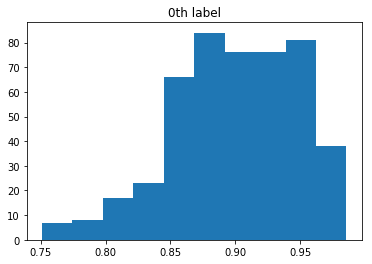

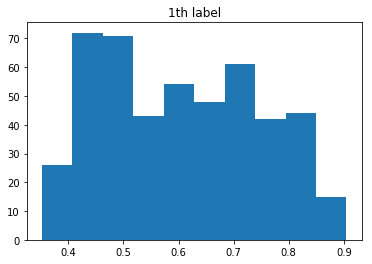

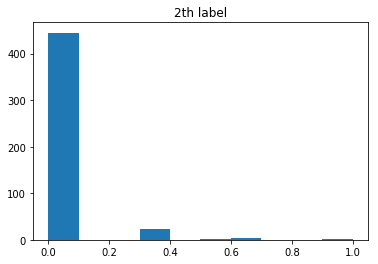

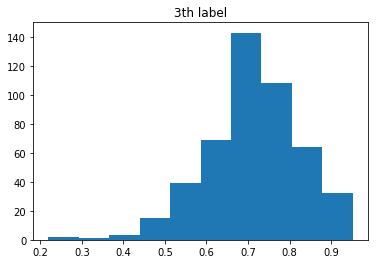

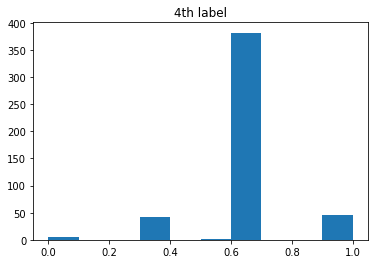

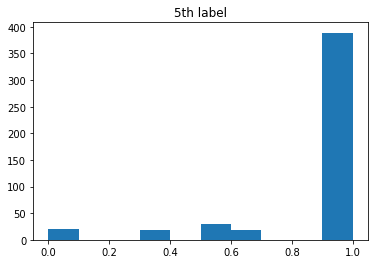

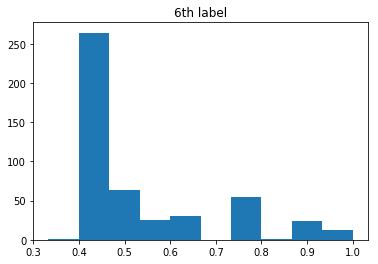

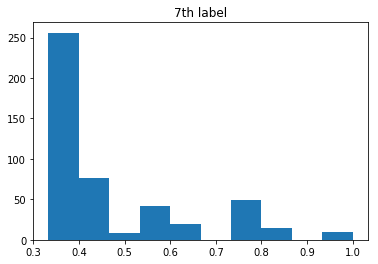

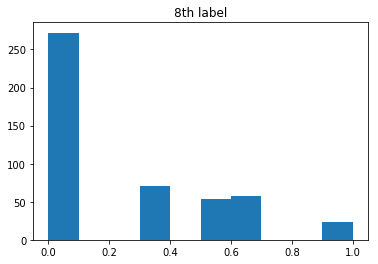

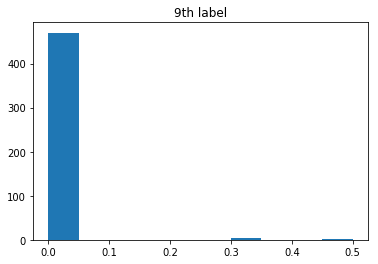

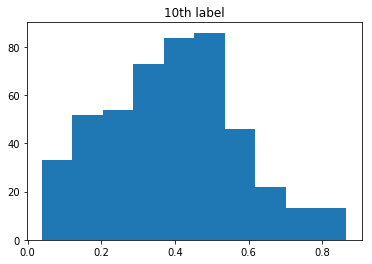

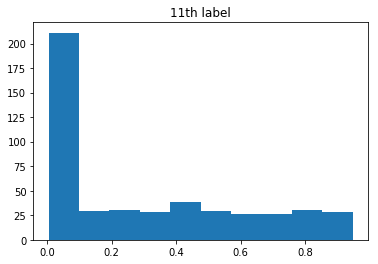

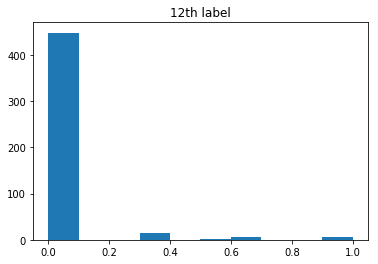

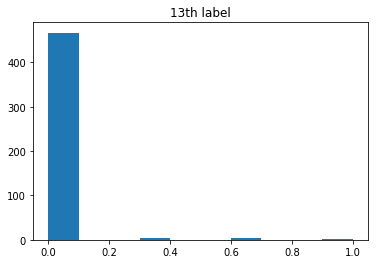

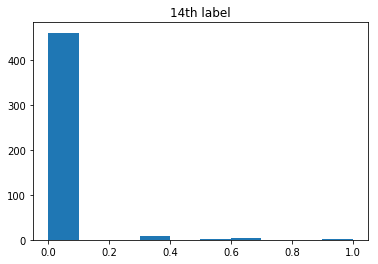

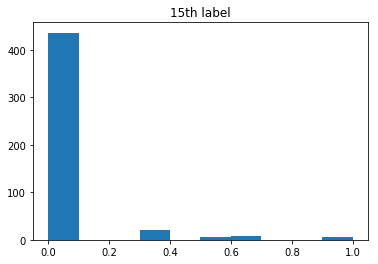

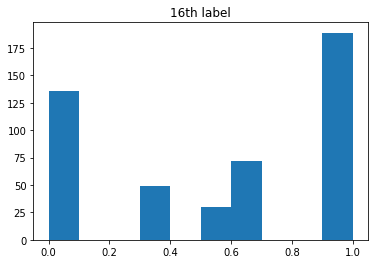

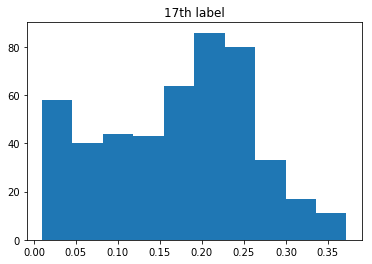

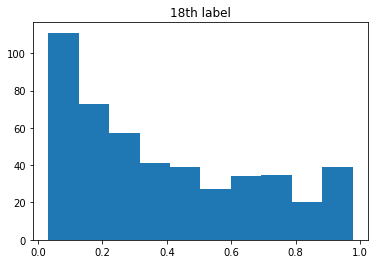

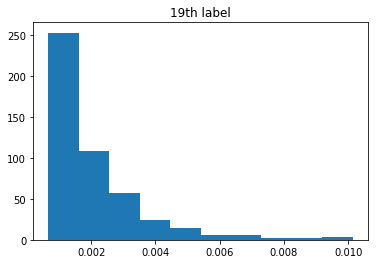

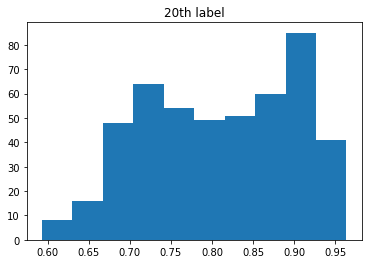

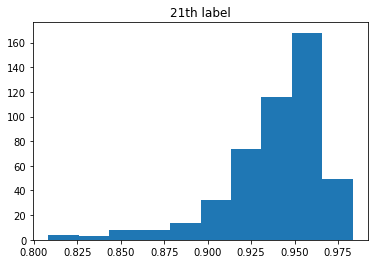

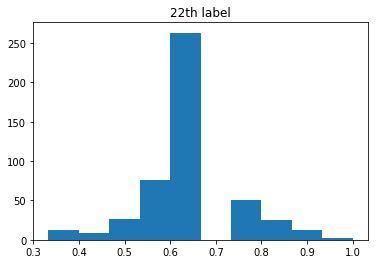

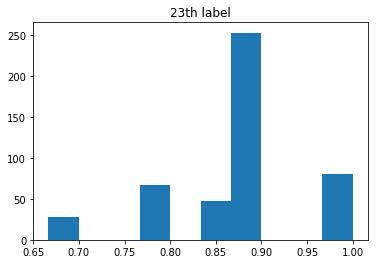

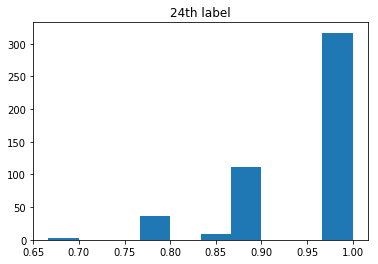

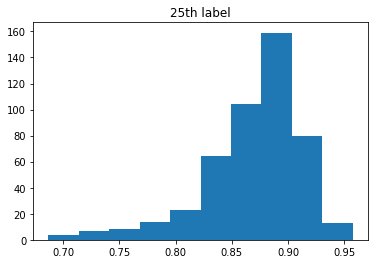

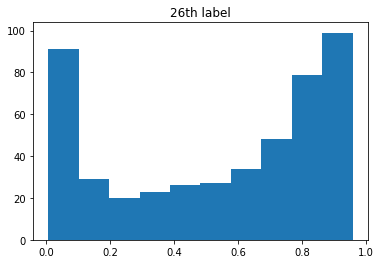

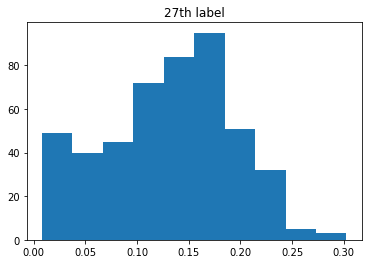

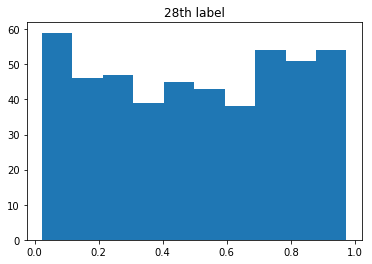

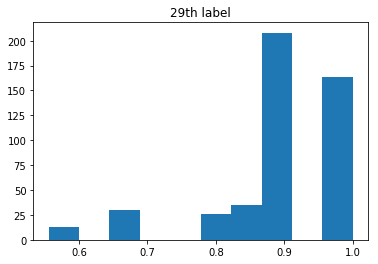

In [37]:
from matplotlib import pyplot as plt

for i in range(30):
    plt.hist(prediction[:, i])
    plt.title(f'{i}th label')
    plt.show()

In [38]:
sub_df = pd.read_csv('/kaggle/input/google-quest-challenge/sample_submission.csv')
sub_df.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,...,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308
1,46,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,...,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448
2,70,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,...,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673
3,132,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,...,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401
4,200,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,...,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074


In [39]:
sub_df.iloc[:, 1:] = prediction
sub_df.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.954155,0.705512,0.333333,0.612035,0.333333,0.333333,0.777778,0.777778,0.666667,...,0.931080,0.924410,0.500000,0.888889,0.888889,0.830216,0.064033,0.039210,0.847333,1.000000
1,46,0.876550,0.470160,0.000000,0.754151,0.666667,1.000000,0.444444,0.333333,0.000000,...,0.664303,0.953868,0.666667,0.888889,1.000000,0.887403,0.925005,0.121108,0.073385,0.777778
2,70,0.923644,0.696060,0.000000,0.848511,0.666667,1.000000,0.444444,0.444444,0.000000,...,0.870782,0.949332,0.555556,0.888889,1.000000,0.868634,0.137375,0.079073,0.885181,0.888889
3,132,0.893433,0.452477,0.000000,0.715947,0.666667,1.000000,0.444444,0.333333,0.000000,...,0.718674,0.962203,0.777778,0.888889,1.000000,0.903242,0.838730,0.163473,0.616455,0.888889
4,200,0.929150,0.457566,0.000000,0.833605,0.666667,1.000000,0.777778,0.777778,0.000000,...,0.703188,0.909879,0.666667,0.833333,0.888889,0.829768,0.139754,0.088044,0.573262,0.888889


## avoid scoring error

In [40]:
pub_qa_id = [39, 46, 70, 132, 200, 245, 257, 267, 284, 292, 296, 312, 322, 327, 334, 340, 357, 374, 375, 387, 391, 395, 444, 482, 483, 513, 542, 579, 589, 625, 641, 683, 725, 727, 728, 740, 748, 765, 811, 830, 851, 856, 885, 905, 929, 938, 939, 962, 1082, 1091, 1101, 1119, 1153, 1226, 1230, 1238, 1247, 1249, 1266, 1282, 1297, 1331, 1359, 1398, 1423, 1477, 1502, 1544, 1567, 1654, 1676, 1700, 1701, 1727, 1764, 1794, 1795, 1807, 1812, 1816, 1833, 1847, 1868, 1877, 1885, 1934, 1959, 1983, 1990, 2005, 2018, 2027, 2042, 2066, 2070, 2075, 2094, 2128, 2163, 2180, 2203, 2230, 2244, 2257, 2277, 2278, 2286, 2303, 2335, 2374, 2387, 2395, 2455, 2465, 2474, 2487, 2493, 2534, 2569, 2573, 2580, 2592, 2607, 2621, 2655, 2666, 2669, 2670, 2676, 2691, 2748, 2763, 2774, 2789, 2793, 2795, 2797, 2806, 2844, 2868, 2895, 2912, 2922, 2931, 2968, 3034, 3062, 3087, 3107, 3173, 3207, 3229, 3290, 3336, 3378, 3399, 3437, 3461, 3463, 3502, 3504, 3524, 3526, 3527, 3532, 3543, 3544, 3560, 3592, 3671, 3682, 3696, 3720, 3787, 3854, 3871, 3876, 3881, 3901, 3941, 3943, 3949, 3961, 3962, 3967, 4006, 4039, 4057, 4070, 4099, 4139, 4157, 4160, 4176, 4182, 4183, 4211, 4213, 4250, 4263, 4269, 4281, 4284, 4285, 4286, 4346, 4387, 4388, 4401, 4416, 4441, 4497, 4546, 4547, 4564, 4569, 4575, 4598, 4607, 4663, 4679, 4743, 4751, 4778, 4792, 4835, 4881, 4901, 4954, 4973, 5001, 5003, 5019, 5035, 5050, 5057, 5076, 5091, 5095, 5141, 5152, 5253, 5367, 5373, 5403, 5417, 5422, 5499, 5503, 5530, 5541, 5542, 5660, 5663, 5697, 5753, 5783, 5790, 5835, 5847, 5862, 5878, 5891, 5904, 5907, 5914, 5936, 5947, 5958, 5972, 5979, 5998, 6016, 6042, 6058, 6079, 6087, 6111, 6126, 6132, 6159, 6204, 6212, 6226, 6258, 6271, 6280, 6285, 6301, 6319, 6325, 6331, 6332, 6336, 6346, 6378, 6379, 6420, 6445, 6481, 6494, 6495, 6502, 6560, 6580, 6583, 6621, 6643, 6646, 6688, 6694, 6715, 6723, 6737, 6744, 6745, 6766, 6770, 6774, 6821, 6832, 6838, 6856, 6888, 6889, 6955, 6957, 6964, 6988, 6994, 7012, 7018, 7036, 7064, 7072, 7114, 7116, 7123, 7150, 7165, 7176, 7194, 7201, 7216, 7247, 7254, 7272, 7278, 7281, 7293, 7302, 7326, 7404, 7410, 7438, 7477, 7481, 7485, 7519, 7520, 7525, 7531, 7544, 7546, 7589, 7595, 7614, 7640, 7654, 7672, 7711, 7727, 7739, 7758, 7766, 7815, 7838, 7852, 7869, 7878, 7899, 7935, 7939, 7970, 8021, 8032, 8045, 8070, 8089, 8115, 8143, 8146, 8191, 8197, 8206, 8212, 8242, 8245, 8250, 8258, 8271, 8273, 8339, 8350, 8355, 8376, 8395, 8412, 8427, 8437, 8464, 8496, 8516, 8517, 8551, 8564, 8591, 8621, 8626, 8629, 8672, 8684, 8685, 8690, 8738, 8755, 8756, 8760, 8771, 8773, 8778, 8823, 8834, 8842, 8846, 8875, 8916, 8921, 8932, 8934, 8938, 8973, 8987, 9001, 9006, 9018, 9033, 9065, 9140, 9141, 9174, 9213, 9225, 9228, 9237, 9240, 9256, 9259, 9263, 9298, 9324, 9350, 9391, 9400, 9439, 9454, 9476, 9478, 9497, 9545, 9567, 9569, 9590, 9597, 9623, 9640]
# pub_qa_id = [70, 132, 200, 245, 257, 267, 284, 292, 296, 312, 322, 327, 334, 340, 357, 374, 375, 387, 391, 395, 444, 482, 483, 513, 542, 579, 589, 625, 641, 683, 725, 727, 728, 740, 748, 765, 811, 830, 851, 856, 885, 905, 929, 938, 939, 962, 1082, 1091, 1101, 1119, 1153, 1226, 1230, 1238, 1247, 1249, 1266, 1282, 1297, 1331, 1359, 1398, 1423, 1477, 1502, 1544, 1567, 1654, 1676, 1700, 1701, 1727, 1764, 1794, 1795, 1807, 1812, 1816, 1833, 1847, 1868, 1877, 1885, 1934, 1959, 1983, 1990, 2005, 2018, 2027, 2042, 2066, 2070, 2075, 2094, 2128, 2163, 2180, 2203, 2230, 2244, 2257, 2277, 2278, 2286, 2303, 2335, 2374, 2387, 2395, 2455, 2465, 2474, 2487, 2493, 2534, 2569, 2573, 2580, 2592, 2607, 2621, 2655, 2666, 2669, 2670, 2676, 2691, 2748, 2763, 2774, 2789, 2793, 2795, 2797, 2806, 2844, 2868, 2895, 2912, 2922, 2931, 2968, 3034, 3062, 3087, 3107, 3173, 3207, 3229, 3290, 3336, 3378, 3399, 3437, 3461, 3463, 3502, 3504, 3524, 3526, 3527, 3532, 3543, 3544, 3560, 3592, 3671, 3682, 3696, 3720, 3787, 3854, 3871, 3876, 3881, 3901, 3941, 3943, 3949, 3961, 3962, 3967, 4006, 4039, 4057, 4070, 4099, 4139, 4157, 4160, 4176, 4182, 4183, 4211, 4213, 4250, 4263, 4269, 4281, 4284, 4285, 4286, 4346, 4387, 4388, 4401, 4416, 4441, 4497, 4546, 4547, 4564, 4569, 4575, 4598, 4607, 4663, 4679, 4743, 4751, 4778, 4792, 4835, 4881, 4901, 4954, 4973, 5001, 5003, 5019, 5035, 5050, 5057, 5076, 5091, 5095, 5141, 5152, 5253, 5367, 5373, 5403, 5417, 5422, 5499, 5503, 5530, 5541, 5542, 5660, 5663, 5697, 5753, 5783, 5790, 5835, 5847, 5862, 5878, 5891, 5904, 5907, 5914, 5936, 5947, 5958, 5972, 5979, 5998, 6016, 6042, 6058, 6079, 6087, 6111, 6126, 6132, 6159, 6204, 6212, 6226, 6258, 6271, 6280, 6285, 6301, 6319, 6325, 6331, 6332, 6336, 6346, 6378, 6379, 6420, 6445, 6481, 6494, 6495, 6502, 6560, 6580, 6583, 6621, 6643, 6646, 6688, 6694, 6715, 6723, 6737, 6744, 6745, 6766, 6770, 6774, 6821, 6832, 6838, 6856, 6888, 6889, 6955, 6957, 6964, 6988, 6994, 7012, 7018, 7036, 7064, 7072, 7114, 7116, 7123, 7150, 7165, 7176, 7194, 7201, 7216, 7247, 7254, 7272, 7278, 7281, 7293, 7302, 7326, 7404, 7410, 7438, 7477, 7481, 7485, 7519, 7520, 7525, 7531, 7544, 7546, 7589, 7595, 7614, 7640, 7654, 7672, 7711, 7727, 7739, 7758, 7766, 7815, 7838, 7852, 7869, 7878, 7899, 7935, 7939, 7970, 8021, 8032, 8045, 8070, 8089, 8115, 8143, 8146, 8191, 8197, 8206, 8212, 8242, 8245, 8250, 8258, 8271, 8273, 8339, 8350, 8355, 8376, 8395, 8412, 8427, 8437, 8464, 8496, 8516, 8517, 8551, 8564, 8591, 8621, 8626, 8629, 8672, 8684, 8685, 8690, 8738, 8755, 8756, 8760, 8771, 8773, 8778, 8823, 8834, 8842, 8846, 8875, 8916, 8921, 8932, 8934, 8938, 8973, 8987, 9001, 9006, 9018, 9033, 9065, 9140, 9141, 9174, 9213, 9225, 9228, 9237, 9240, 9256, 9259, 9263, 9298, 9324, 9350, 9391, 9400, 9439, 9454, 9476, 9478, 9497, 9545, 9567, 9569, 9590, 9597, 9623, 9640]

In [41]:
sub_df_cols = sub_df.columns[1:]
sub_df_cols

Index(['question_asker_intent_understanding', 'question_body_critical',
       'question_conversational', 'question_expect_short_answer',
       'question_fact_seeking', 'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written'],
      dtype='object')

In [42]:
for i in range(30):
    sub_df_col = sub_df_cols[i]

    pub_y_pred = raw_prediction[sub_df.qa_id.isin(pub_qa_id).values, i]
    pub_y_res = sub_df.loc[sub_df.qa_id.isin(pub_qa_id).values, sub_df_col].values

    pub_y_pred_argmax = np.argmax(pub_y_pred)
    pub_y_pred_argmin = np.argmin(pub_y_pred)

    if len(np.unique(pub_y_res)) == 1:
        if np.unique(pub_y_res)[0] == pub_y_pred[pub_y_pred_argmax]:
            if np.unique(pub_y_res)[0] == pub_y_pred[pub_y_pred_argmin]:
                if np.unique(pub_y_res)[0] > 0.5:
                    pub_y_res[pub_y_pred_argmin] = 0
                else:
                    pub_y_res[pub_y_pred_argmax] = 1
            else:
                pub_y_res[pub_y_pred_argmin] = np.min(pub_y_pred)                
        else:
            pub_y_res[pub_y_pred_argmax] = np.max(pub_y_pred)
    sub_df.loc[sub_df.qa_id.isin(pub_qa_id).values, sub_df_col] = pub_y_res


    pri_y_pred = raw_prediction[~(sub_df.qa_id.isin(pub_qa_id).values), i]

    # only for sub
    if len(pri_y_pred) == 0:
        continue    
    pri_y_res = sub_df.loc[~(sub_df.qa_id.isin(pub_qa_id).values), sub_df_col].values  
    
    pri_y_pred_argmax = np.argmax(pri_y_pred)
    pri_y_pred_argmin = np.argmin(pri_y_pred)    

    if len(np.unique(pri_y_res)) == 1:
        if np.unique(pri_y_res)[0] == pri_y_pred[pri_y_pred_argmax]:
            if np.unique(pri_y_res)[0] == pri_y_pred[pri_y_pred_argmin]:
                if np.unique(pri_y_res)[0] > 0.5:
                    pri_y_res[pri_y_pred_argmin] = 0
                else:
                    pri_y_res[pri_y_pred_argmax] = 1
            else:
                pri_y_res[pri_y_pred_argmin] = np.min(pri_y_pred)                
        else:
            pri_y_res[pri_y_pred_argmax] = np.max(pri_y_pred)
        
    sub_df.loc[~(sub_df.qa_id.isin(pub_qa_id).values), sub_df_col] = pri_y_res    

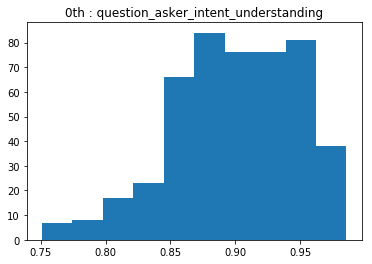

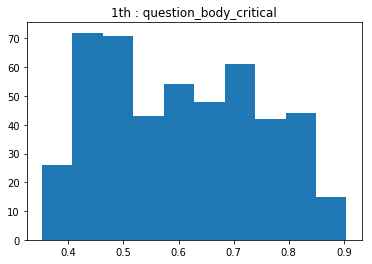

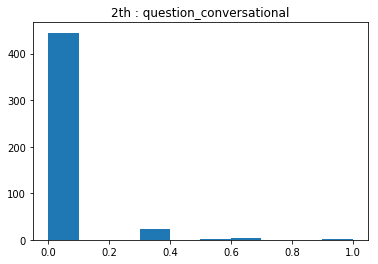

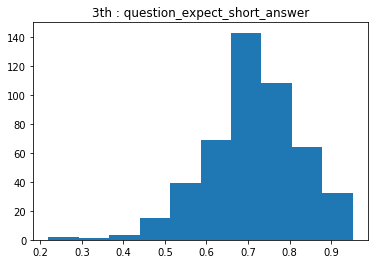

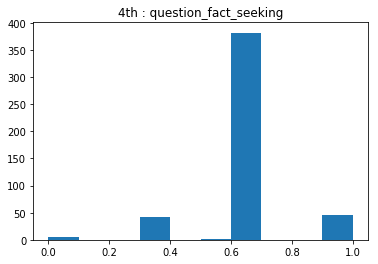

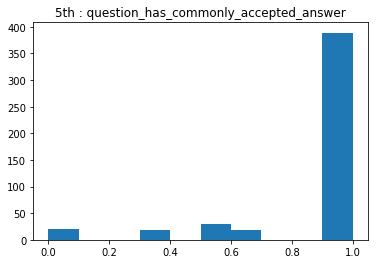

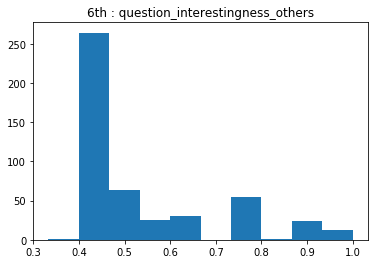

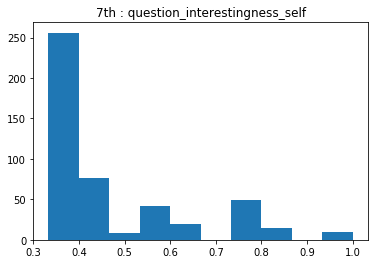

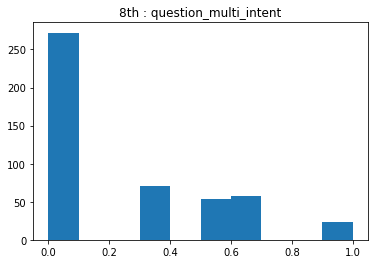

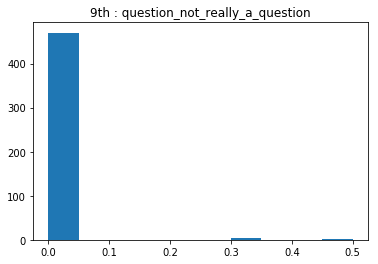

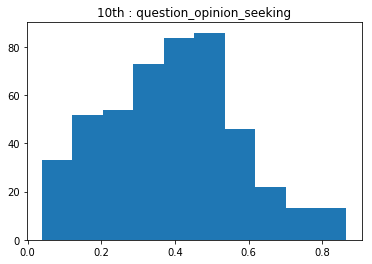

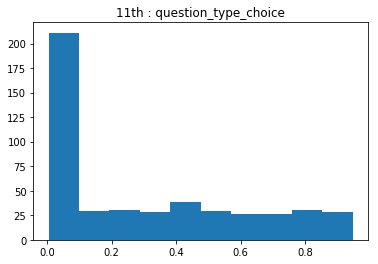

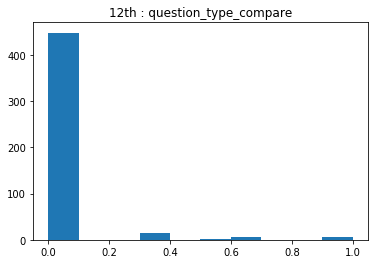

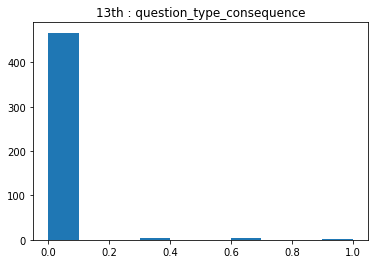

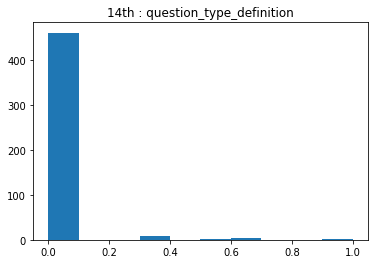

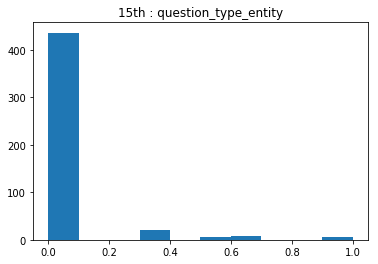

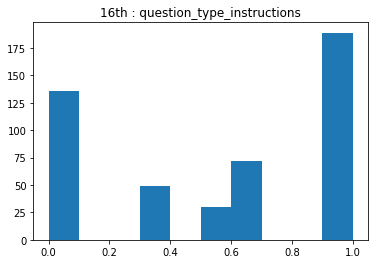

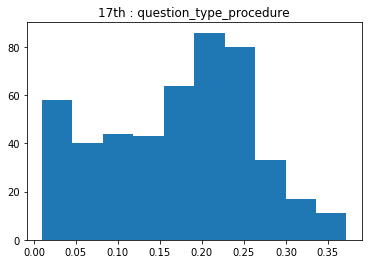

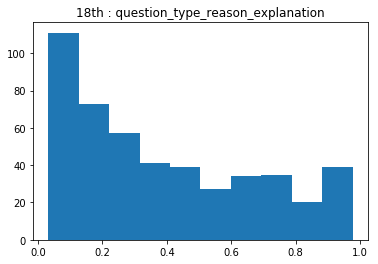

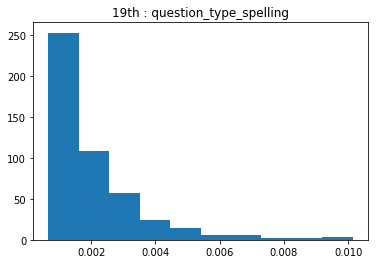

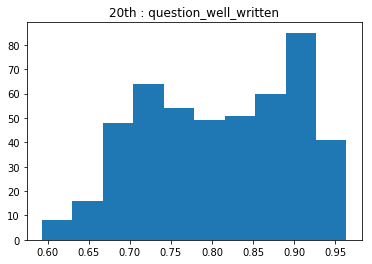

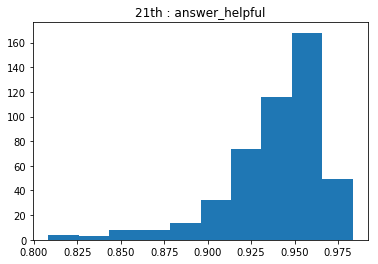

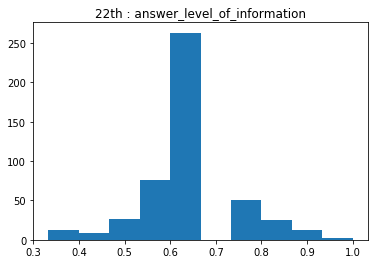

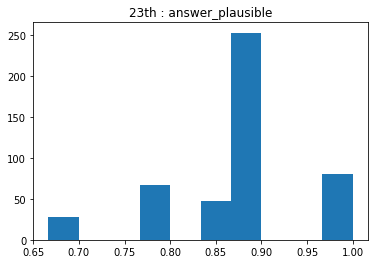

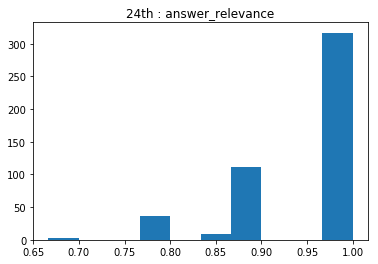

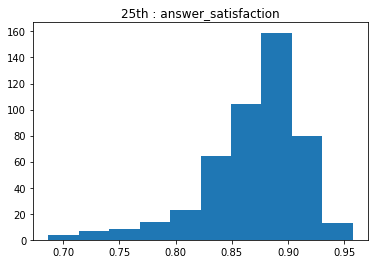

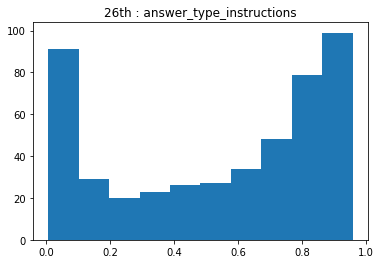

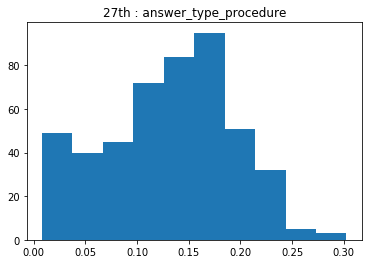

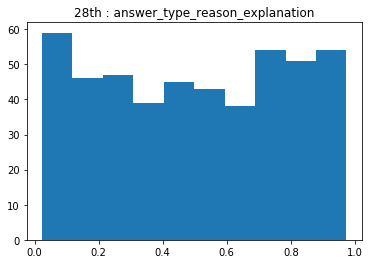

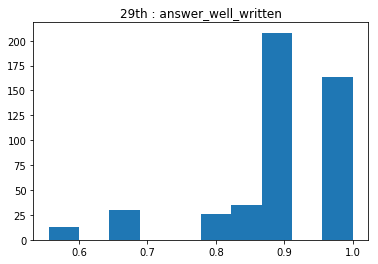

In [43]:
for i in range(30):
    plt.hist(sub_df.iloc[:, i+1])
    plt.title(f'{i}th : {sub_df.columns[i+1]}')
    plt.show()

In [44]:
sub_df.to_csv("submission.csv", index=False)